# System-level

### Optimisation

This code presents the system-level analysis for the optimization problem. This involved the combination of the light and cost subsytems. The objective of this analysis is to find optimal positions to iluminate a room with lamps while accounting for a limited budget. 

During the system- level analysis different weighting for the light subsytem were analysed. The most effective solution resulted with a weight of 0.2. In order to reduce the computational cost of this example, only this case will be represented.

In [1]:
import time
import numpy as np
import numpy.ma as ma
import operator as op
import matplotlib.pyplot as plt
from scipy.optimize import minimize, BFGS, LinearConstraint, NonlinearConstraint

The following code imports the model parameter class, which includes the parameter for the light and cost subsystem. 

In [2]:
class MP:
    """
    Enum to hold some of the Model Parameters
    """

    """ 
    Global Parameters
    """

    # Discretisation step
    DXY = 0.01

    # Room geometry
    ROOM_LENGTH = 4
    ROOM_WIDTH = 3
    ROOM_HEIGHT = 2.3
    F_PLUG_POSITION = [2.3, 0.05]
    S_PLUG_POSITION = [3.95, 2]


    # Number of lamps
    N_LAMPS = 3

    # Parameters
    LAMP_EFFICIENCY = 0.8
    LAMP_RADII = [0.1, 0.2, 0.1]

    POWER_SCALING_FACTOR = 1
    LAMP_POW = [50, 120, 50]
    LAMP_POW = np.array(LAMP_POW) * POWER_SCALING_FACTOR

    # Albedo
    ALBEDO = 0.5
    BOUNCES = 3

    # Plot parameters
    N_LEVELS = 20

    """
    Light Quality Subsystem
    """

    # Initial lamp location guess (design variables: [x1, y1, x2, y2, x3, y3])
    INITIAL_GUESS_LAMP_LOCS = np.array([0.68978269, 0.98767149, 1.78447148, 2.79305784, 3.66072114, 2.4])

    # Linear Constraint Matrix
    CONSTRAINT_MAT = [[1, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]]

    # Lamp 1: Bed: Bound Constraints (x1, y1)
    G1 = [LAMP_RADII[0], 2.3 - LAMP_RADII[0]]
    G2 = [LAMP_RADII[0], 1.5 - LAMP_RADII[0]]

    # Lamp 2: Floor: Bound Constraints (x2, y2)
    G3 = [0.4 + LAMP_RADII[1], 2.3 - LAMP_RADII[1]]
    G4 = [0.9 + LAMP_RADII[1], 3 - LAMP_RADII[1]]

    # Lamp 3: Desk: Bound Constraints (x3, y3)
    G5 = [2.3 + LAMP_RADII[2], 4 - LAMP_RADII[2]]
    G6 = [1.1 + LAMP_RADII[2], 3 - LAMP_RADII[2]]

    CONSTRAINTS = [G1, G2, G3, G4, G5, G6]

    # Linear Constraint Bounds
    LOWER_BOUND = [constraint[0] for constraint in CONSTRAINTS]
    UPPER_BOUND = [constraint[1] for constraint in CONSTRAINTS]

    """
    Cost Subsystem
    """

    # Cost
    CABLE_COST = 2
    WORK_COST = 40
    ENERGY_COST = 0.12
    AVG_HOURS_PER_YEAR = float(2500 / 1000)
    INVESTMENT_FACTOR = 3
    # Bea's add
    # Initial characteristics for lamps
    INITIAL_SOLUTION = np.array([0.68978269, 0.98767149, 1.78447148, 2.79305784, 3.66072114, 2.22234, 0.2])

    # Efficiency, in a range from 0 to 1
    G7 = [0.2, 1]

    CONSTRAINT_MAT_EXT = [[1, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1]]

    # Add all constrains to limit all variables to 0

    CONSTRAINTS_EXT = [G1, G2, G3, G4, G5, G6, G7]

    # Linear Constraint Bounds
    LOWER_BOUND_EXT = [constraint[0] for constraint in CONSTRAINTS_EXT]
    UPPER_BOUND_EXT = [constraint[1] for constraint in CONSTRAINTS_EXT]

    """
    System Level

    """

    # Weight of different subsystems
    WEIGHT_LIGHT = 0.5
    WEIGHT_COST = 1 - WEIGHT_LIGHT

"""
FUNCTIONAL CONSTRAINTS
"""

def functional_constraint(variables):
    c_cable_tot = 0
    total_power = sum(MP.LAMP_POW)

    for i in range(3):
        c_cable_tot += (abs(variables[2 * i]) + abs(variables[2 * i + 1])) + 1.6
        c_cable_tot = c_cable_tot * MP.CABLE_COST

    lamp_efficiency = variables[6]
    c_operation = (total_power / lamp_efficiency) * MP.AVG_HOURS_PER_YEAR * MP.ENERGY_COST
    c_lamp = (lamp_efficiency / 0.2)
    c_tot_lamp_cost = MP.N_LAMPS * c_lamp
    c_work = np.log(MP.N_LAMPS) * MP.WORK_COST
    c_initial = (c_cable_tot + c_tot_lamp_cost + c_work)

    return c_initial - MP.INVESTMENT_FACTOR * c_operation

class Room:
    """
    The Room class contains the space in which the lighting optimisation will take place
    """

    def __init__(self, length, width):

        self.x = np.arange(0, length, MP.DXY)
        self.y = np.arange(0, width, MP.DXY)
        self.xx, self.yy = np.meshgrid(self.x, self.y, sparse=True)


Once the parameters are imported the intensisity distribution and cost functions are run. 

In [3]:
def get_intensity_distr(lamp_locs, refl=False):
    """
    Calculates the intensity distribution within a room with n number of light sources
    """

    room = Room(MP.ROOM_LENGTH, MP.ROOM_WIDTH)

    # No reflections
    if not refl:

        for i in range(MP.N_LAMPS):
            # Multiply by discretisation step to be in metres
            distance_to_lamp_n = ((room.xx - lamp_locs[2 * i]) ** 2 + (room.yy - lamp_locs[2 * i + 1]) ** 2)

            # Take out the value that are less than a radius away from the light source
            distance_to_lamp_n_filtered = ma.masked_less(np.sqrt(distance_to_lamp_n), MP.LAMP_RADII[i])

            if i == 0:
                # Initialise the light intensity array
                light_intensity = np.zeros_like(distance_to_lamp_n_filtered)

            # Find light intensity distribution
            light_intensity_n = ((MP.LAMP_EFFICIENCY * MP.LAMP_POW[i]) /
                                 (4 * np.pi)) / (distance_to_lamp_n_filtered * MP.DXY)

            light_intensity += light_intensity_n

        minimum = np.amin(light_intensity)
        minimum_coordinates = np.unravel_index(np.argmin(light_intensity), light_intensity.shape)

        return light_intensity, minimum, minimum_coordinates

    # With reflections
    elif refl:

        initialised = False

        # The first loop takes care of wall reflections
        for i in range(- MP.BOUNCES // 2, MP.BOUNCES // 2 + 1):
            # The second loop takes care of the three different lamps
            for j in range(MP.N_LAMPS):

                x_jk = 0.5 * (1 + (-1) ** i) * lamp_locs[2 * j] + \
                       0.5 * (1 - (-1) ** i) * (MP.ROOM_LENGTH - lamp_locs[2 * j])
                y_jk = 0.5 * (1 + (-1) ** i) * lamp_locs[2 * j + 1] + \
                       0.5 * (1 - (-1) ** i) * (MP.ROOM_WIDTH - lamp_locs[2 * j + 1])

                distance_to_lamp_n = ((room.xx - (x_jk - MP.ROOM_LENGTH * i)) ** 2 +
                                      (room.yy - (y_jk - MP.ROOM_WIDTH * i)) ** 2)

                # Take out the value that are less than a radius away from the light source
                distance_to_lamp_n_filtered = ma.masked_less(np.sqrt(distance_to_lamp_n), MP.LAMP_RADII[j])

                # Initialise the light intensity array
                if not initialised:
                    light_intensity = np.zeros_like(distance_to_lamp_n_filtered)
                    initialised = True

                # Find light intensity distribution
                light_intensity_n = ((MP.ALBEDO ** (abs(2 * i))) * (MP.LAMP_EFFICIENCY * MP.LAMP_POW[j]) /
                                     (4 * np.pi)) / (distance_to_lamp_n_filtered * MP.DXY)

                # Increment light intensity array
                light_intensity += light_intensity_n

        minimum = np.amin(light_intensity)
        minimum_coordinates = np.unravel_index(np.argmin(light_intensity), light_intensity.shape)

        return light_intensity, minimum, minimum_coordinates


In [4]:
def cost_obj_fun(variables):
    """
    Cost objective function. Vars is [x1, y1, x2, y2, x3, y3, e, i]
    Where c is equal for the three lamps and is equal to the the characteristics of lamp composed by price and efficiency
    """
    #Total cable cost is initialised
    c_cable_tot = 0

    # The power is fixed, so the total power is a sum of the power of all the lamps
    total_power = sum(MP.LAMP_POW)

    '''
    There are 7 variables in total
    In a range of 3 - which equals for iterations,  i = 0,1 and 2 will refer to each of the lamps. 
    The code will consider which considers i and i+1 for x, y  
    '''
    #Start the loop to calculate cable length
    for i in range(3):
        #Calcilate total length, including 1.6 m for the height of the lamps in the room.
        c_cable_tot += (abs(variables[2 * i]) + abs(variables[2 * i + 1])) + 1.6
        #Calculate the total price
        c_cable_tot = c_cable_tot * MP.CABLE_COST

    lamp_efficiency = variables[6]
    # Calculate the operation cost in terms of the efficiency
    c_operation = (total_power/lamp_efficiency) * MP.AVG_HOURS_PER_YEAR * MP.ENERGY_COST

    #Calculate the lamp cost in terms of the efficiency
    c_lamp = (lamp_efficiency/0.2)

    # Calculate total lamp cost
    c_tot_lamp_cost = MP.N_LAMPS * c_lamp

    # Calculate work cost
    c_work = np.log(MP.N_LAMPS) * MP.WORK_COST

    #Caltulate the initial cost
    c_initial = (c_cable_tot + c_tot_lamp_cost + c_work)

    #Caltulate total cost
    c_tot = c_initial + c_operation

    return c_tot




The trust constr algorithm is utlised for the system-level optimization. In this case, as stated in the introduction of this jupyter notebook, the solution will only be calculated for a weight of 0.2 for the light subsystem. 

In [5]:
class TrustConstrModel:
    """
    Two-dimensional model of light distribution in a plane with n number of light sources
    """

    def __init__(self, weight_light = False):

        # To keep track of the iterations
        self.counter = 0

        # Parameters
        self.name = 'Trust-Constr'
        self.refl = True
        self.save_fig = True
        self.save_log = False
        self.constrained = True

        if not weight_light:
            self.weight_light = MP.WEIGHT_LIGHT
        else:
            self.weight_light = weight_light

        if self.save_log:
            self.data = []

        if self.constrained:
            self.constraints = (LinearConstraint(MP.CONSTRAINT_MAT_EXT, MP.LOWER_BOUND_EXT, MP.UPPER_BOUND_EXT),
                                NonlinearConstraint(functional_constraint, -np.inf, 0, jac='cs', hess=BFGS()))
        else:
            self.constraints = ()

        print("Welcome! You are using a trust-constr optimiser.")
        print("Reflections: ", self.refl)
        print("Constraints: ", self.constrained)

        time.sleep(1)
        # Objective function. We want to maximise this

        self.result = minimize(self.obj_fun, MP.INITIAL_SOLUTION, method='trust-constr', jac='3-point',
                            constraints=self.constraints, hess=BFGS(exception_strategy='damp_update'))

        # What is the result of the optimisation?
        print(self.result)

    def obj_fun(self, vars):
        """
        Objective function to be minimised. This maximises the ratio between the minimum light intensity and total cost.
        """

        # Calculate current intensity distribution
        light_intensity, minimum, minimum_coordinates = get_intensity_distr(vars, refl=self.refl)

        # Calculate total cost of given distribution
        total_cost = cost_obj_fun(vars)

        # Since we want to maximise with a minimisation approach we need to minimise the negative function value
        print("Iteration: ", self.counter, " Variables: ", [round(var, 2) for var in vars], " Minimum: ", round(minimum, 2), " Cost: ",
              round(total_cost, 2))
        self.counter += 1

        return (1 - self.weight_light) * total_cost - self.weight_light * minimum


Welcome! You are using a trust-constr optimiser.
Reflections:  True
Constraints:  True
Iteration:  0  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  1  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  2  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  3  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  4  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  5  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  6  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  7  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  8  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  44

Iteration:  79  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  80  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  81  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  82  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  83  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  84  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  85  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  86  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  87  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  88  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Mi

Iteration:  159  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  160  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  161  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  162  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  163  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  164  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  165  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  166  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  167  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  168  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Mi

Iteration:  240  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  241  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  242  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  243  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  244  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  245  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  246  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  247  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  248  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  249  Variables:  [0.74, 0.91, 1.71, 2.59, 3

Iteration:  319  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  320  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  321  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  322  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  323  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  324  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  325  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  326  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  327  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  328  Variables:  [0.74, 0.91, 1.71, 2.58, 3

Iteration:  400  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  401  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  402  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  403  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  404  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  405  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  406  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  407  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  408  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  409  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81

Iteration:  481  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  482  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  483  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  484  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  485  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  486  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  487  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  488  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  489  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  490  Variables:  [0.73, 0.89, 1.72, 2.56, 3

Iteration:  560  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  561  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  562  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  563  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  564  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  565  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  566  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  567  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  568  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  569  Variables:  [0.73, 0.89, 1.73, 2.55, 3

Iteration:  641  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  642  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  643  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  644  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  645  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  646  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  647  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  648  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  649  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  650  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 

Iteration:  721  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  722  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  723  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  724  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  725  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  726  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  727  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  728  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  729  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  730  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1,

Iteration:  801  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  802  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  803  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  804  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  805  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  806  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  807  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  808  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  809  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  810  Variables:  [0.73, 0.87, 1.74, 2.52, 3

Iteration:  881  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  882  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  883  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  884  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  885  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  886  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  887  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  888  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  889  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  890  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08

Iteration:  961  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  962  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  963  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  964  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  965  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  966  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  967  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  968  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  969  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  970  Variables:  [0.73, 0.86, 1.75, 2.51, 3

Iteration:  1040  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1041  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1042  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1043  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1044  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1045  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1046  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.81  Cost:  188.49
Iteration:  1047  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1048  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1049  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.0

Iteration:  1120  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.19  Cost:  188.39
Iteration:  1121  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.19  Cost:  188.39
Iteration:  1122  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.19  Cost:  188.39
Iteration:  1123  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.19  Cost:  188.39
Iteration:  1124  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.19  Cost:  188.39
Iteration:  1125  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.47  Cost:  188.37
Iteration:  1126  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.47  Cost:  188.37
Iteration:  1127  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.47  Cost:  188.37
Iteration:  1128  Variables:  [0.73, 0.84, 1.76, 2.49, 3.56, 2.04, 0.99]  Minimum:  620.47  Cost:  188.37
Iteration:  1129  Variables:  [0.73, 0.84, 1.7

Iteration:  1198  Variables:  [0.73, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.59  Cost:  188.3
Iteration:  1199  Variables:  [0.73, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.59  Cost:  188.3
Iteration:  1200  Variables:  [0.72, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.88  Cost:  188.28
Iteration:  1201  Variables:  [0.72, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.88  Cost:  188.28
Iteration:  1202  Variables:  [0.72, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.88  Cost:  188.28
Iteration:  1203  Variables:  [0.72, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.88  Cost:  188.28
Iteration:  1204  Variables:  [0.72, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.88  Cost:  188.28
Iteration:  1205  Variables:  [0.72, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.88  Cost:  188.28
Iteration:  1206  Variables:  [0.72, 0.84, 1.76, 2.48, 3.56, 2.03, 0.99]  Minimum:  621.88  Cost:  188.28
Iteration:  1207  Variables:  [0.72, 0.84, 1.76,

Iteration:  1277  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1278  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1279  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1280  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1281  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1282  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1283  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1284  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1285  Variables:  [0.72, 0.83, 1.77, 2.47, 3.56, 2.02, 0.99]  Minimum:  623.31  Cost:  188.18
Iteration:  1286  Variables:  [0.72, 0.83, 1.7

Iteration:  1356  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.58  Cost:  188.07
Iteration:  1357  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.58  Cost:  188.07
Iteration:  1358  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.58  Cost:  188.07
Iteration:  1359  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.58  Cost:  188.07
Iteration:  1360  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.58  Cost:  188.07
Iteration:  1361  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.59  Cost:  188.07
Iteration:  1362  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.58  Cost:  188.07
Iteration:  1363  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.58  Cost:  188.07
Iteration:  1364  Variables:  [0.72, 0.82, 1.77, 2.46, 3.56, 2.01, 0.99]  Minimum:  624.58  Cost:  188.07
Iteration:  1365  Variables:  [0.72, 0.82, 1.7

Iteration:  1436  Variables:  [0.72, 0.82, 1.77, 2.45, 3.56, 2.0, 0.99]  Minimum:  625.85  Cost:  187.96
Iteration:  1437  Variables:  [0.72, 0.82, 1.77, 2.45, 3.56, 2.0, 0.99]  Minimum:  625.85  Cost:  187.96
Iteration:  1438  Variables:  [0.72, 0.82, 1.77, 2.45, 3.56, 2.0, 0.99]  Minimum:  625.85  Cost:  187.96
Iteration:  1439  Variables:  [0.72, 0.82, 1.77, 2.45, 3.56, 2.0, 0.99]  Minimum:  625.85  Cost:  187.96
Iteration:  1440  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.99, 0.99]  Minimum:  626.11  Cost:  187.94
Iteration:  1441  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.99, 0.99]  Minimum:  626.11  Cost:  187.94
Iteration:  1442  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.99, 0.99]  Minimum:  626.11  Cost:  187.94
Iteration:  1443  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.99, 0.99]  Minimum:  626.11  Cost:  187.94
Iteration:  1444  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.99, 0.99]  Minimum:  626.11  Cost:  187.94
Iteration:  1445  Variables:  [0.72, 0.81, 1.77, 2

Iteration:  1517  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1518  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1519  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1520  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1521  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1522  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1523  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1524  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1525  Variables:  [0.72, 0.81, 1.77, 2.45, 3.56, 1.98, 0.99]  Minimum:  627.39  Cost:  187.82
Iteration:  1526  Variables:  [0.72, 0.81, 1.7

Iteration:  1598  Variables:  [0.72, 0.8, 1.77, 2.44, 3.56, 1.97, 0.99]  Minimum:  628.7  Cost:  187.71
Iteration:  1599  Variables:  [0.72, 0.8, 1.77, 2.44, 3.56, 1.97, 0.99]  Minimum:  628.7  Cost:  187.71
Iteration:  1600  Variables:  [0.72, 0.8, 1.77, 2.44, 3.56, 1.97, 0.99]  Minimum:  628.7  Cost:  187.71
Iteration:  1601  Variables:  [0.72, 0.8, 1.77, 2.44, 3.56, 1.97, 0.99]  Minimum:  628.71  Cost:  187.71
Iteration:  1602  Variables:  [0.72, 0.8, 1.77, 2.44, 3.56, 1.97, 0.99]  Minimum:  628.7  Cost:  187.71
Iteration:  1603  Variables:  [0.72, 0.8, 1.77, 2.44, 3.56, 1.97, 0.99]  Minimum:  628.7  Cost:  187.71
Iteration:  1604  Variables:  [0.72, 0.8, 1.77, 2.44, 3.56, 1.97, 0.99]  Minimum:  628.7  Cost:  187.71
Iteration:  1605  Variables:  [0.72, 0.8, 1.77, 2.44, 3.57, 1.97, 0.99]  Minimum:  628.97  Cost:  187.69
Iteration:  1606  Variables:  [0.72, 0.8, 1.77, 2.44, 3.57, 1.97, 0.99]  Minimum:  628.97  Cost:  187.69
Iteration:  1607  Variables:  [0.72, 0.8, 1.77, 2.44, 3.57, 1

Iteration:  1676  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.96, 0.99]  Minimum:  630.01  Cost:  187.6
Iteration:  1677  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.96, 0.99]  Minimum:  630.01  Cost:  187.6
Iteration:  1678  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.96, 0.99]  Minimum:  630.01  Cost:  187.6
Iteration:  1679  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.96, 0.99]  Minimum:  630.01  Cost:  187.6
Iteration:  1680  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.95, 0.99]  Minimum:  630.28  Cost:  187.57
Iteration:  1681  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.95, 0.99]  Minimum:  630.28  Cost:  187.57
Iteration:  1682  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.95, 0.99]  Minimum:  630.28  Cost:  187.57
Iteration:  1683  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.95, 0.99]  Minimum:  630.28  Cost:  187.57
Iteration:  1684  Variables:  [0.72, 0.79, 1.78, 2.43, 3.57, 1.95, 0.99]  Minimum:  630.28  Cost:  187.57
Iteration:  1685  Variables:  [0.72, 0.79, 1.78, 2

Iteration:  1756  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1757  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1758  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1759  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1760  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1761  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1762  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1763  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1764  Variables:  [0.72, 0.78, 1.78, 2.43, 3.57, 1.94, 0.99]  Minimum:  631.56  Cost:  187.46
Iteration:  1765  Variables:  [0.72, 0.78, 1.7

Iteration:  1834  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.91  Cost:  187.35
Iteration:  1835  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.91  Cost:  187.35
Iteration:  1836  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.92  Cost:  187.35
Iteration:  1837  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.92  Cost:  187.35
Iteration:  1838  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.91  Cost:  187.35
Iteration:  1839  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.91  Cost:  187.35
Iteration:  1840  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.92  Cost:  187.35
Iteration:  1841  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.92  Cost:  187.35
Iteration:  1842  Variables:  [0.72, 0.77, 1.78, 2.42, 3.57, 1.93, 0.99]  Minimum:  632.91  Cost:  187.35
Iteration:  1843  Variables:  [0.72, 0.77, 1.7

Iteration:  1914  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.92, 0.99]  Minimum:  634.31  Cost:  187.23
Iteration:  1915  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.92, 0.99]  Minimum:  634.31  Cost:  187.23
Iteration:  1916  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.92, 0.99]  Minimum:  634.31  Cost:  187.23
Iteration:  1917  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.92, 0.99]  Minimum:  634.31  Cost:  187.23
Iteration:  1918  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.92, 0.99]  Minimum:  634.31  Cost:  187.23
Iteration:  1919  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.92, 0.99]  Minimum:  634.31  Cost:  187.23
Iteration:  1920  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.91, 0.99]  Minimum:  634.59  Cost:  187.2
Iteration:  1921  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.91, 0.99]  Minimum:  634.59  Cost:  187.2
Iteration:  1922  Variables:  [0.72, 0.76, 1.78, 2.41, 3.57, 1.91, 0.99]  Minimum:  634.59  Cost:  187.2
Iteration:  1923  Variables:  [0.72, 0.76, 1.78, 

Iteration:  1993  Variables:  [0.71, 0.75, 1.78, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.7  Cost:  187.11
Iteration:  1994  Variables:  [0.71, 0.75, 1.78, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.7  Cost:  187.11
Iteration:  1995  Variables:  [0.71, 0.75, 1.79, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.95  Cost:  187.09
Iteration:  1996  Variables:  [0.71, 0.75, 1.79, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.95  Cost:  187.09
Iteration:  1997  Variables:  [0.71, 0.75, 1.79, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.95  Cost:  187.09
Iteration:  1998  Variables:  [0.71, 0.75, 1.79, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.95  Cost:  187.09
Iteration:  1999  Variables:  [0.71, 0.75, 1.79, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.95  Cost:  187.09
Iteration:  2000  Variables:  [0.71, 0.75, 1.79, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.95  Cost:  187.09
Iteration:  2001  Variables:  [0.71, 0.75, 1.79, 2.41, 3.57, 1.9, 0.99]  Minimum:  635.95  Cost:  187.09
Iteration:  2002  Variables:  [0.71, 0.75, 1.79, 2.41, 3.

Iteration:  2075  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2076  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2077  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2078  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2079  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2080  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2081  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2082  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2083  Variables:  [0.71, 0.74, 1.79, 2.4, 3.57, 1.89, 0.99]  Minimum:  637.38  Cost:  186.96
Iteration:  2084  Variables:  [0.71, 0.74, 1.79, 2.4, 3

Iteration:  2153  Variables:  [0.71, 0.74, 1.79, 2.39, 3.57, 1.88, 0.99]  Minimum:  638.84  Cost:  186.84
Iteration:  2154  Variables:  [0.71, 0.74, 1.79, 2.39, 3.57, 1.88, 0.99]  Minimum:  638.84  Cost:  186.84
Iteration:  2155  Variables:  [0.71, 0.74, 1.79, 2.39, 3.57, 1.88, 0.99]  Minimum:  638.84  Cost:  186.84
Iteration:  2156  Variables:  [0.71, 0.74, 1.79, 2.39, 3.57, 1.88, 0.99]  Minimum:  638.84  Cost:  186.84
Iteration:  2157  Variables:  [0.71, 0.74, 1.79, 2.39, 3.57, 1.88, 0.99]  Minimum:  638.84  Cost:  186.84
Iteration:  2158  Variables:  [0.71, 0.74, 1.79, 2.39, 3.57, 1.88, 0.99]  Minimum:  638.84  Cost:  186.84
Iteration:  2159  Variables:  [0.71, 0.74, 1.79, 2.39, 3.57, 1.88, 0.99]  Minimum:  638.84  Cost:  186.84
Iteration:  2160  Variables:  [0.71, 0.73, 1.79, 2.39, 3.57, 1.87, 0.99]  Minimum:  639.14  Cost:  186.82
Iteration:  2161  Variables:  [0.71, 0.73, 1.79, 2.39, 3.57, 1.87, 0.99]  Minimum:  639.14  Cost:  186.82
Iteration:  2162  Variables:  [0.71, 0.73, 1.7

Iteration:  2234  Variables:  [0.71, 0.73, 1.79, 2.39, 3.57, 1.86, 0.99]  Minimum:  640.33  Cost:  186.72
Iteration:  2235  Variables:  [0.71, 0.73, 1.79, 2.38, 3.57, 1.86, 0.99]  Minimum:  640.63  Cost:  186.69
Iteration:  2236  Variables:  [0.71, 0.73, 1.79, 2.38, 3.57, 1.86, 0.99]  Minimum:  640.63  Cost:  186.69
Iteration:  2237  Variables:  [0.71, 0.73, 1.79, 2.38, 3.57, 1.86, 0.99]  Minimum:  640.64  Cost:  186.69
Iteration:  2238  Variables:  [0.71, 0.73, 1.79, 2.38, 3.57, 1.86, 0.99]  Minimum:  640.63  Cost:  186.69
Iteration:  2239  Variables:  [0.71, 0.73, 1.79, 2.38, 3.57, 1.86, 0.99]  Minimum:  640.63  Cost:  186.69
Iteration:  2240  Variables:  [0.71, 0.73, 1.79, 2.38, 3.57, 1.86, 0.99]  Minimum:  640.63  Cost:  186.69
Iteration:  2241  Variables:  [0.71, 0.73, 1.79, 2.38, 3.57, 1.86, 0.99]  Minimum:  640.64  Cost:  186.69
Iteration:  2242  Variables:  [0.71, 0.73, 1.79, 2.38, 3.57, 1.86, 0.99]  Minimum:  640.64  Cost:  186.69
Iteration:  2243  Variables:  [0.71, 0.73, 1.7

Iteration:  2313  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2314  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2315  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2316  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2317  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2318  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2319  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2320  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2321  Variables:  [0.71, 0.72, 1.79, 2.38, 3.57, 1.85, 0.99]  Minimum:  642.14  Cost:  186.57
Iteration:  2322  Variables:  [0.71, 0.72, 1.7

Iteration:  2393  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.59  Cost:  186.45
Iteration:  2394  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.59  Cost:  186.45
Iteration:  2395  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.59  Cost:  186.45
Iteration:  2396  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.59  Cost:  186.45
Iteration:  2397  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.59  Cost:  186.45
Iteration:  2398  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.59  Cost:  186.45
Iteration:  2399  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.59  Cost:  186.45
Iteration:  2400  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.9  Cost:  186.42
Iteration:  2401  Variables:  [0.71, 0.71, 1.8, 2.37, 3.57, 1.83, 0.99]  Minimum:  643.9  Cost:  186.42
Iteration:  2402  Variables:  [0.71, 0.71, 1.8, 2.37, 3.5

Iteration:  2472  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.16  Cost:  186.32
Iteration:  2473  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.16  Cost:  186.32
Iteration:  2474  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.16  Cost:  186.32
Iteration:  2475  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.48  Cost:  186.29
Iteration:  2476  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.48  Cost:  186.29
Iteration:  2477  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.48  Cost:  186.29
Iteration:  2478  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.48  Cost:  186.29
Iteration:  2479  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.48  Cost:  186.29
Iteration:  2480  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Minimum:  645.48  Cost:  186.29
Iteration:  2481  Variables:  [0.7, 0.7, 1.8, 2.36, 3.57, 1.82, 0.99]  Mi

Iteration:  2552  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.08  Cost:  186.16
Iteration:  2553  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.08  Cost:  186.16
Iteration:  2554  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.08  Cost:  186.16
Iteration:  2555  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.07  Cost:  186.16
Iteration:  2556  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.08  Cost:  186.16
Iteration:  2557  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.08  Cost:  186.16
Iteration:  2558  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.07  Cost:  186.16
Iteration:  2559  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.07  Cost:  186.16
Iteration:  2560  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Minimum:  647.08  Cost:  186.16
Iteration:  2561  Variables:  [0.7, 0.69, 1.8, 2.36, 3.57, 1.8, 0.99]  Mi

Iteration:  2634  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  648.72  Cost:  186.03
Iteration:  2635  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  648.72  Cost:  186.03
Iteration:  2636  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  648.72  Cost:  186.03
Iteration:  2637  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  648.72  Cost:  186.03
Iteration:  2638  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  648.72  Cost:  186.03
Iteration:  2639  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  648.72  Cost:  186.03
Iteration:  2640  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  649.05  Cost:  186.01
Iteration:  2641  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  649.05  Cost:  186.01
Iteration:  2642  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79, 0.99]  Minimum:  649.05  Cost:  186.01
Iteration:  2643  Variables:  [0.7, 0.68, 1.8, 2.35, 3.57, 1.79,

Iteration:  2714  Variables:  [0.7, 0.67, 1.8, 2.34, 3.58, 1.78, 0.99]  Minimum:  650.34  Cost:  185.9
Iteration:  2715  Variables:  [0.7, 0.67, 1.81, 2.34, 3.58, 1.77, 0.99]  Minimum:  650.68  Cost:  185.88
Iteration:  2716  Variables:  [0.7, 0.67, 1.81, 2.34, 3.58, 1.77, 0.99]  Minimum:  650.68  Cost:  185.88
Iteration:  2717  Variables:  [0.7, 0.67, 1.81, 2.34, 3.58, 1.77, 0.99]  Minimum:  650.68  Cost:  185.88
Iteration:  2718  Variables:  [0.7, 0.67, 1.81, 2.34, 3.58, 1.77, 0.99]  Minimum:  650.68  Cost:  185.88
Iteration:  2719  Variables:  [0.7, 0.67, 1.81, 2.34, 3.58, 1.77, 0.99]  Minimum:  650.68  Cost:  185.88
Iteration:  2720  Variables:  [0.7, 0.67, 1.81, 2.34, 3.58, 1.77, 0.99]  Minimum:  650.67  Cost:  185.88
Iteration:  2721  Variables:  [0.7, 0.67, 1.81, 2.34, 3.58, 1.77, 0.99]  Minimum:  650.68  Cost:  185.88
Iteration:  2722  Variables:  [0.7, 0.67, 1.81, 2.34, 3.58, 1.77, 0.99]  Minimum:  650.68  Cost:  185.88
Iteration:  2723  Variables:  [0.7, 0.67, 1.81, 2.34, 3.5

Iteration:  2796  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2797  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2798  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2799  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2800  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2801  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2802  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2803  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2804  Variables:  [0.7, 0.66, 1.81, 2.33, 3.58, 1.76, 0.99]  Minimum:  652.39  Cost:  185.74
Iteration:  2805  Variables:  [0.7, 0.66, 1.81, 2.33, 3

Iteration:  2876  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.75, 0.99]  Minimum:  654.13  Cost:  185.61
Iteration:  2877  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.75, 0.99]  Minimum:  654.13  Cost:  185.61
Iteration:  2878  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.75, 0.99]  Minimum:  654.13  Cost:  185.61
Iteration:  2879  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.75, 0.99]  Minimum:  654.13  Cost:  185.61
Iteration:  2880  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.74, 0.99]  Minimum:  654.48  Cost:  185.58
Iteration:  2881  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.74, 0.99]  Minimum:  654.48  Cost:  185.58
Iteration:  2882  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.74, 0.99]  Minimum:  654.48  Cost:  185.58
Iteration:  2883  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.74, 0.99]  Minimum:  654.48  Cost:  185.58
Iteration:  2884  Variables:  [0.7, 0.65, 1.81, 2.33, 3.58, 1.74, 0.99]  Minimum:  654.48  Cost:  185.58
Iteration:  2885  Variables:  [0.7, 0.65, 1.81, 2.33, 3

Iteration:  2954  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  655.89  Cost:  185.47
Iteration:  2955  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  656.25  Cost:  185.44
Iteration:  2956  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  656.25  Cost:  185.44
Iteration:  2957  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  656.25  Cost:  185.44
Iteration:  2958  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  656.25  Cost:  185.44
Iteration:  2959  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  656.25  Cost:  185.44
Iteration:  2960  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  656.25  Cost:  185.44
Iteration:  2961  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  656.25  Cost:  185.44
Iteration:  2962  Variables:  [0.69, 0.64, 1.81, 2.32, 3.58, 1.73, 0.99]  Minimum:  656.25  Cost:  185.44
Iteration:  2963  Variables:  [0.69, 0.64, 1.8

Iteration:  3035  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3036  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3037  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3038  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3039  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3040  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3041  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3042  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3043  Variables:  [0.69, 0.63, 1.81, 2.31, 3.58, 1.72, 0.99]  Minimum:  658.09  Cost:  185.31
Iteration:  3044  Variables:  [0.69, 0.63, 1.8

Iteration:  3113  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  659.94  Cost:  185.17
Iteration:  3114  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  659.94  Cost:  185.17
Iteration:  3115  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  659.94  Cost:  185.17
Iteration:  3116  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  659.94  Cost:  185.17
Iteration:  3117  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  659.94  Cost:  185.17
Iteration:  3118  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  659.94  Cost:  185.17
Iteration:  3119  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  659.94  Cost:  185.17
Iteration:  3120  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  660.27  Cost:  185.14
Iteration:  3121  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7, 0.99]  Minimum:  660.27  Cost:  185.14
Iteration:  3122  Variables:  [0.69, 0.62, 1.82, 2.3, 3.58, 1.7,

Iteration:  3195  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3196  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3197  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3198  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3199  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3200  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3201  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3202  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3203  Variables:  [0.69, 0.61, 1.82, 2.3, 3.58, 1.68, 0.99]  Minimum:  662.14  Cost:  185.01
Iteration:  3204  Variables:  [0.69, 0.61, 1.82, 2.3, 3

Iteration:  3273  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3274  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3275  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3276  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3277  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3278  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3279  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3280  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3281  Variables:  [0.69, 0.6, 1.82, 2.29, 3.58, 1.67, 0.99]  Minimum:  664.01  Cost:  184.87
Iteration:  3282  Variables:  [0.69, 0.6, 1.82, 2.29, 3

Iteration:  3353  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.66, 0.99]  Minimum:  665.95  Cost:  184.73
Iteration:  3354  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.66, 0.99]  Minimum:  665.95  Cost:  184.73
Iteration:  3355  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.66, 0.99]  Minimum:  665.95  Cost:  184.73
Iteration:  3356  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.66, 0.99]  Minimum:  665.95  Cost:  184.73
Iteration:  3357  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.66, 0.99]  Minimum:  665.95  Cost:  184.73
Iteration:  3358  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.66, 0.99]  Minimum:  665.95  Cost:  184.73
Iteration:  3359  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.66, 0.99]  Minimum:  665.95  Cost:  184.73
Iteration:  3360  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.65, 0.99]  Minimum:  666.36  Cost:  184.7
Iteration:  3361  Variables:  [0.68, 0.59, 1.82, 2.28, 3.58, 1.65, 0.99]  Minimum:  666.36  Cost:  184.7
Iteration:  3362  Variables:  [0.68, 0.59, 1.82,

Iteration:  3433  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  667.99  Cost:  184.58
Iteration:  3434  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  667.99  Cost:  184.58
Iteration:  3435  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  668.41  Cost:  184.55
Iteration:  3436  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  668.41  Cost:  184.55
Iteration:  3437  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  668.41  Cost:  184.55
Iteration:  3438  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  668.41  Cost:  184.55
Iteration:  3439  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  668.41  Cost:  184.55
Iteration:  3440  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  668.41  Cost:  184.55
Iteration:  3441  Variables:  [0.68, 0.58, 1.83, 2.27, 3.58, 1.64, 0.99]  Minimum:  668.41  Cost:  184.55
Iteration:  3442  Variables:  [0.68, 0.58, 1.8

Iteration:  3511  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3512  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3513  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3514  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3515  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3516  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3517  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3518  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3519  Variables:  [0.68, 0.57, 1.83, 2.26, 3.58, 1.62, 0.99]  Minimum:  670.42  Cost:  184.41
Iteration:  3520  Variables:  [0.68, 0.57, 1.8

Iteration:  3589  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3590  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3591  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3592  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3593  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3594  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3595  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3596  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3597  Variables:  [0.68, 0.56, 1.83, 2.26, 3.58, 1.61, 0.99]  Minimum:  672.56  Cost:  184.26
Iteration:  3598  Variables:  [0.68, 0.56, 1.8

Iteration:  3668  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  674.72  Cost:  184.11
Iteration:  3669  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  674.72  Cost:  184.11
Iteration:  3670  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  674.72  Cost:  184.11
Iteration:  3671  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  674.72  Cost:  184.11
Iteration:  3672  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  674.72  Cost:  184.11
Iteration:  3673  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  674.72  Cost:  184.11
Iteration:  3674  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  674.72  Cost:  184.11
Iteration:  3675  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  675.18  Cost:  184.08
Iteration:  3676  Variables:  [0.68, 0.55, 1.83, 2.25, 3.58, 1.59, 0.99]  Minimum:  675.17  Cost:  184.08
Iteration:  3677  Variables:  [0.68, 0.55, 1.8

Iteration:  3747  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  676.98  Cost:  183.96
Iteration:  3748  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  676.98  Cost:  183.96
Iteration:  3749  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  676.98  Cost:  183.96
Iteration:  3750  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  677.37  Cost:  183.93
Iteration:  3751  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  677.37  Cost:  183.93
Iteration:  3752  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  677.37  Cost:  183.93
Iteration:  3753  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  677.37  Cost:  183.93
Iteration:  3754  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  677.37  Cost:  183.93
Iteration:  3755  Variables:  [0.67, 0.54, 1.83, 2.24, 3.58, 1.58, 0.99]  Minimum:  677.37  Cost:  183.93
Iteration:  3756  Variables:  [0.67, 0.54, 1.8

Iteration:  3825  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3826  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3827  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3828  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3829  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3830  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3831  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3832  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3833  Variables:  [0.67, 0.53, 1.84, 2.23, 3.58, 1.56, 0.99]  Minimum:  679.72  Cost:  183.78
Iteration:  3834  Variables:  [0.67, 0.53, 1.8

Iteration:  3904  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3905  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3906  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3907  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3908  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3909  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3910  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3911  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3912  Variables:  [0.67, 0.52, 1.84, 2.22, 3.58, 1.55, 0.99]  Minimum:  681.88  Cost:  183.64
Iteration:  3913  Variables:  [0.67, 0.52, 1.8

Iteration:  3983  Variables:  [0.67, 0.51, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.4  Cost:  183.48
Iteration:  3984  Variables:  [0.67, 0.51, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.4  Cost:  183.48
Iteration:  3985  Variables:  [0.67, 0.51, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.4  Cost:  183.48
Iteration:  3986  Variables:  [0.67, 0.51, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.4  Cost:  183.48
Iteration:  3987  Variables:  [0.67, 0.51, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.4  Cost:  183.48
Iteration:  3988  Variables:  [0.67, 0.51, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.4  Cost:  183.48
Iteration:  3989  Variables:  [0.67, 0.51, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.4  Cost:  183.48
Iteration:  3990  Variables:  [0.67, 0.5, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.91  Cost:  183.45
Iteration:  3991  Variables:  [0.67, 0.5, 1.84, 2.21, 3.58, 1.53, 0.99]  Minimum:  684.91  Cost:  183.45
Iteration:  3992  Variables:  [0.67, 0.5, 1.84, 2.21, 3

Iteration:  4062  Variables:  [0.67, 0.5, 1.84, 2.21, 3.58, 1.51, 0.99]  Minimum:  686.94  Cost:  183.33
Iteration:  4063  Variables:  [0.67, 0.5, 1.84, 2.21, 3.58, 1.51, 0.99]  Minimum:  686.94  Cost:  183.33
Iteration:  4064  Variables:  [0.67, 0.5, 1.84, 2.21, 3.58, 1.51, 0.99]  Minimum:  686.94  Cost:  183.33
Iteration:  4065  Variables:  [0.67, 0.49, 1.84, 2.2, 3.58, 1.51, 0.99]  Minimum:  687.39  Cost:  183.3
Iteration:  4066  Variables:  [0.67, 0.49, 1.84, 2.2, 3.58, 1.51, 0.99]  Minimum:  687.39  Cost:  183.3
Iteration:  4067  Variables:  [0.67, 0.49, 1.84, 2.2, 3.58, 1.51, 0.99]  Minimum:  687.39  Cost:  183.3
Iteration:  4068  Variables:  [0.67, 0.49, 1.84, 2.2, 3.58, 1.51, 0.99]  Minimum:  687.39  Cost:  183.3
Iteration:  4069  Variables:  [0.67, 0.49, 1.84, 2.2, 3.58, 1.51, 0.99]  Minimum:  687.39  Cost:  183.3
Iteration:  4070  Variables:  [0.67, 0.49, 1.84, 2.2, 3.58, 1.51, 0.99]  Minimum:  687.39  Cost:  183.3
Iteration:  4071  Variables:  [0.67, 0.49, 1.84, 2.2, 3.58, 1

Iteration:  4144  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.01  Cost:  183.14
Iteration:  4145  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.01  Cost:  183.14
Iteration:  4146  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.01  Cost:  183.14
Iteration:  4147  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.01  Cost:  183.14
Iteration:  4148  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.01  Cost:  183.14
Iteration:  4149  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.01  Cost:  183.14
Iteration:  4150  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.01  Cost:  183.14
Iteration:  4151  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.02  Cost:  183.14
Iteration:  4152  Variables:  [0.66, 0.48, 1.85, 2.2, 3.58, 1.49, 0.99]  Minimum:  690.01  Cost:  183.14
Iteration:  4153  Variables:  [0.66, 0.48, 1.85, 2.2, 3

Iteration:  4223  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.48, 0.99]  Minimum:  692.73  Cost:  182.98
Iteration:  4224  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.48, 0.99]  Minimum:  692.73  Cost:  182.98
Iteration:  4225  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.48, 0.99]  Minimum:  692.73  Cost:  182.98
Iteration:  4226  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.48, 0.99]  Minimum:  692.73  Cost:  182.98
Iteration:  4227  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.48, 0.99]  Minimum:  692.73  Cost:  182.98
Iteration:  4228  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.48, 0.99]  Minimum:  692.73  Cost:  182.98
Iteration:  4229  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.48, 0.99]  Minimum:  692.73  Cost:  182.98
Iteration:  4230  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.47, 0.99]  Minimum:  693.29  Cost:  182.95
Iteration:  4231  Variables:  [0.66, 0.47, 1.85, 2.19, 3.59, 1.47, 0.99]  Minimum:  693.29  Cost:  182.95
Iteration:  4232  Variables:  [0.66, 0.47, 1.8

Iteration:  4302  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.39  Cost:  182.83
Iteration:  4303  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.39  Cost:  182.83
Iteration:  4304  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.39  Cost:  182.83
Iteration:  4305  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.97  Cost:  182.8
Iteration:  4306  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.97  Cost:  182.8
Iteration:  4307  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.97  Cost:  182.8
Iteration:  4308  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.97  Cost:  182.8
Iteration:  4309  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.97  Cost:  182.8
Iteration:  4310  Variables:  [0.66, 0.46, 1.85, 2.18, 3.59, 1.46, 0.99]  Minimum:  695.97  Cost:  182.8
Iteration:  4311  Variables:  [0.66, 0.46, 1.85, 2.1

Iteration:  4381  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4382  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4383  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4384  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4385  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4386  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4387  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4388  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4389  Variables:  [0.66, 0.45, 1.86, 2.17, 3.59, 1.44, 0.99]  Minimum:  698.92  Cost:  182.63
Iteration:  4390  Variables:  [0.66, 0.45, 1.8

Iteration:  4461  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4462  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4463  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4464  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4465  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4466  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4467  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4468  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4469  Variables:  [0.66, 0.44, 1.86, 2.16, 3.59, 1.42, 0.99]  Minimum:  701.98  Cost:  182.46
Iteration:  4470  Variables:  [0.66, 0.43, 1.8

Iteration:  4539  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.17  Cost:  182.29
Iteration:  4540  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.17  Cost:  182.29
Iteration:  4541  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.17  Cost:  182.29
Iteration:  4542  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.17  Cost:  182.29
Iteration:  4543  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.17  Cost:  182.29
Iteration:  4544  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.17  Cost:  182.29
Iteration:  4545  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.82  Cost:  182.26
Iteration:  4546  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.82  Cost:  182.26
Iteration:  4547  Variables:  [0.65, 0.42, 1.86, 2.15, 3.59, 1.4, 0.99]  Minimum:  705.82  Cost:  182.26
Iteration:  4548  Variables:  [0.65, 0.42, 1.86, 2.15, 

Iteration:  4619  Variables:  [0.65, 0.41, 1.86, 2.14, 3.59, 1.39, 0.99]  Minimum:  708.49  Cost:  182.13
Iteration:  4620  Variables:  [0.65, 0.41, 1.87, 2.14, 3.59, 1.38, 0.99]  Minimum:  709.17  Cost:  182.1
Iteration:  4621  Variables:  [0.65, 0.41, 1.87, 2.14, 3.59, 1.38, 0.99]  Minimum:  709.17  Cost:  182.1
Iteration:  4622  Variables:  [0.65, 0.41, 1.87, 2.14, 3.59, 1.38, 0.99]  Minimum:  709.17  Cost:  182.1
Iteration:  4623  Variables:  [0.65, 0.41, 1.87, 2.14, 3.59, 1.38, 0.99]  Minimum:  709.17  Cost:  182.1
Iteration:  4624  Variables:  [0.65, 0.41, 1.87, 2.14, 3.59, 1.38, 0.99]  Minimum:  709.17  Cost:  182.1
Iteration:  4625  Variables:  [0.65, 0.41, 1.87, 2.14, 3.59, 1.38, 0.99]  Minimum:  709.17  Cost:  182.1
Iteration:  4626  Variables:  [0.65, 0.41, 1.87, 2.14, 3.59, 1.38, 0.99]  Minimum:  709.18  Cost:  182.1
Iteration:  4627  Variables:  [0.65, 0.41, 1.87, 2.14, 3.59, 1.38, 0.99]  Minimum:  709.18  Cost:  182.1
Iteration:  4628  Variables:  [0.65, 0.41, 1.87, 2.14,

Iteration:  4701  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.5  Cost:  182.0
Iteration:  4702  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.5  Cost:  182.0
Iteration:  4703  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.5  Cost:  182.0
Iteration:  4704  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.49  Cost:  182.0
Iteration:  4705  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.5  Cost:  182.0
Iteration:  4706  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.5  Cost:  182.0
Iteration:  4707  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.49  Cost:  182.0
Iteration:  4708  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.5  Cost:  182.0
Iteration:  4709  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.5  Cost:  182.0
Iteration:  4710  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]

Iteration:  4783  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.54  Cost:  181.98
Iteration:  4784  Variables:  [0.65, 0.4, 1.87, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.54  Cost:  181.98
Iteration:  4785  Variables:  [0.65, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.6  Cost:  181.96
Iteration:  4786  Variables:  [0.65, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.6  Cost:  181.96
Iteration:  4787  Variables:  [0.65, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.6  Cost:  181.96
Iteration:  4788  Variables:  [0.65, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.6  Cost:  181.96
Iteration:  4789  Variables:  [0.65, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.6  Cost:  181.96
Iteration:  4790  Variables:  [0.65, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.6  Cost:  181.96
Iteration:  4791  Variables:  [0.65, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.6  Cost:  181.96
Iteration:  4792  Variables:  [0.65, 0.4, 1.86, 2.13, 3.59, 1.

Iteration:  4863  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4864  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4865  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4866  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4867  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4868  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4869  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4870  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4871  Variables:  [0.64, 0.4, 1.86, 2.13, 3.59, 1.37, 0.99]  Minimum:  710.72  Cost:  181.88
Iteration:  4872  Variables:  [0.64, 0.4, 1.86, 2.13, 3

Iteration:  4943  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.91  Cost:  181.8
Iteration:  4944  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.91  Cost:  181.8
Iteration:  4945  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.91  Cost:  181.8
Iteration:  4946  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.91  Cost:  181.8
Iteration:  4947  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.91  Cost:  181.8
Iteration:  4948  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.91  Cost:  181.8
Iteration:  4949  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.91  Cost:  181.79
Iteration:  4950  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.96  Cost:  181.77
Iteration:  4951  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1.37, 0.99]  Minimum:  710.96  Cost:  181.77
Iteration:  4952  Variables:  [0.64, 0.4, 1.86, 2.13, 3.58, 1

Iteration:  5023  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.03  Cost:  181.68
Iteration:  5024  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.03  Cost:  181.68
Iteration:  5025  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.12  Cost:  181.66
Iteration:  5026  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.12  Cost:  181.66
Iteration:  5027  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.12  Cost:  181.66
Iteration:  5028  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.12  Cost:  181.66
Iteration:  5029  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.12  Cost:  181.66
Iteration:  5030  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.12  Cost:  181.66
Iteration:  5031  Variables:  [0.63, 0.4, 1.86, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.12  Cost:  181.66
Iteration:  5032  Variables:  [0.63, 0.4, 1.86, 2.12, 3

Iteration:  5105  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.39  Cost:  181.56
Iteration:  5106  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.39  Cost:  181.56
Iteration:  5107  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.39  Cost:  181.56
Iteration:  5108  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.39  Cost:  181.56
Iteration:  5109  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.39  Cost:  181.56
Iteration:  5110  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.39  Cost:  181.56
Iteration:  5111  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.4  Cost:  181.56
Iteration:  5112  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.39  Cost:  181.56
Iteration:  5113  Variables:  [0.62, 0.4, 1.85, 2.12, 3.58, 1.36, 0.99]  Minimum:  711.39  Cost:  181.56
Iteration:  5114  Variables:  [0.62, 0.4, 1.85, 2.12, 3.

Iteration:  5185  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.64  Cost:  181.45
Iteration:  5186  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.64  Cost:  181.45
Iteration:  5187  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.64  Cost:  181.45
Iteration:  5188  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.64  Cost:  181.45
Iteration:  5189  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.64  Cost:  181.45
Iteration:  5190  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.57  Cost:  181.43
Iteration:  5191  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.57  Cost:  181.43
Iteration:  5192  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.57  Cost:  181.43
Iteration:  5193  Variables:  [0.61, 0.4, 1.85, 2.12, 3.57, 1.36, 0.99]  Minimum:  711.57  Cost:  181.43
Iteration:  5194  Variables:  [0.61, 0.4, 1.85, 2.12, 3

Iteration:  5265  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5266  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5267  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5268  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5269  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5270  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5271  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5272  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5273  Variables:  [0.61, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  711.87  Cost:  181.32
Iteration:  5274  Variables:  [0.61, 0.39, 1.8

Iteration:  5347  Variables:  [0.6, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  712.01  Cost:  181.21
Iteration:  5348  Variables:  [0.6, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  712.02  Cost:  181.21
Iteration:  5349  Variables:  [0.6, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  712.02  Cost:  181.21
Iteration:  5350  Variables:  [0.6, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  712.01  Cost:  181.21
Iteration:  5351  Variables:  [0.6, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  712.01  Cost:  181.21
Iteration:  5352  Variables:  [0.6, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  712.01  Cost:  181.21
Iteration:  5353  Variables:  [0.6, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  712.01  Cost:  181.21
Iteration:  5354  Variables:  [0.6, 0.39, 1.85, 2.11, 3.57, 1.35, 0.99]  Minimum:  712.01  Cost:  181.21
Iteration:  5355  Variables:  [0.6, 0.39, 1.85, 2.11, 3.56, 1.35, 0.99]  Minimum:  712.1  Cost:  181.19
Iteration:  5356  Variables:  [0.6, 0.39, 1.85, 2.11, 3.

Iteration:  5427  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.35, 0.99]  Minimum:  712.27  Cost:  181.11
Iteration:  5428  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.35, 0.99]  Minimum:  712.27  Cost:  181.11
Iteration:  5429  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.35, 0.99]  Minimum:  712.27  Cost:  181.11
Iteration:  5430  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.21  Cost:  181.08
Iteration:  5431  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.21  Cost:  181.08
Iteration:  5432  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.21  Cost:  181.08
Iteration:  5433  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.21  Cost:  181.08
Iteration:  5434  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.21  Cost:  181.08
Iteration:  5435  Variables:  [0.59, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.21  Cost:  181.08
Iteration:  5436  Variables:  [0.59, 0.39, 1.84, 2.1, 3

Iteration:  5507  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.45  Cost:  180.98
Iteration:  5508  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.45  Cost:  180.98
Iteration:  5509  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.45  Cost:  180.98
Iteration:  5510  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.44  Cost:  180.98
Iteration:  5511  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.45  Cost:  180.98
Iteration:  5512  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.45  Cost:  180.98
Iteration:  5513  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.44  Cost:  180.98
Iteration:  5514  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.44  Cost:  180.98
Iteration:  5515  Variables:  [0.58, 0.39, 1.84, 2.1, 3.56, 1.34, 0.99]  Minimum:  712.45  Cost:  180.98
Iteration:  5516  Variables:  [0.58, 0.39, 1.84, 2.1, 3

Iteration:  5587  Variables:  [0.58, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.72  Cost:  180.87
Iteration:  5588  Variables:  [0.58, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.72  Cost:  180.87
Iteration:  5589  Variables:  [0.58, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.72  Cost:  180.87
Iteration:  5590  Variables:  [0.58, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.72  Cost:  180.87
Iteration:  5591  Variables:  [0.58, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.72  Cost:  180.87
Iteration:  5592  Variables:  [0.58, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.72  Cost:  180.87
Iteration:  5593  Variables:  [0.58, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.72  Cost:  180.87
Iteration:  5594  Variables:  [0.58, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.72  Cost:  180.87
Iteration:  5595  Variables:  [0.57, 0.39, 1.84, 2.1, 3.55, 1.34, 0.99]  Minimum:  712.78  Cost:  180.85
Iteration:  5596  Variables:  [0.57, 0.39, 1.84, 2.1, 3

Iteration:  5667  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.86  Cost:  180.77
Iteration:  5668  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.86  Cost:  180.77
Iteration:  5669  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.86  Cost:  180.77
Iteration:  5670  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.96  Cost:  180.75
Iteration:  5671  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.96  Cost:  180.75
Iteration:  5672  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.96  Cost:  180.75
Iteration:  5673  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.96  Cost:  180.75
Iteration:  5674  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.96  Cost:  180.75
Iteration:  5675  Variables:  [0.57, 0.39, 1.84, 2.09, 3.55, 1.33, 0.99]  Minimum:  712.96  Cost:  180.75
Iteration:  5676  Variables:  [0.57, 0.39, 1.8

Iteration:  5747  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5748  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5749  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5750  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5751  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5752  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5753  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5754  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5755  Variables:  [0.56, 0.39, 1.83, 2.09, 3.55, 1.33, 0.99]  Minimum:  713.04  Cost:  180.64
Iteration:  5756  Variables:  [0.56, 0.39, 1.8

Iteration:  5827  Variables:  [0.55, 0.39, 1.83, 2.09, 3.54, 1.33, 0.99]  Minimum:  713.33  Cost:  180.56
Iteration:  5828  Variables:  [0.55, 0.39, 1.83, 2.09, 3.54, 1.33, 0.99]  Minimum:  713.33  Cost:  180.56
Iteration:  5829  Variables:  [0.55, 0.39, 1.83, 2.09, 3.54, 1.33, 0.99]  Minimum:  713.33  Cost:  180.56
Iteration:  5830  Variables:  [0.55, 0.39, 1.83, 2.09, 3.54, 1.33, 0.99]  Minimum:  713.33  Cost:  180.56
Iteration:  5831  Variables:  [0.55, 0.39, 1.83, 2.09, 3.54, 1.33, 0.99]  Minimum:  713.33  Cost:  180.56
Iteration:  5832  Variables:  [0.55, 0.39, 1.83, 2.09, 3.54, 1.33, 0.99]  Minimum:  713.33  Cost:  180.56
Iteration:  5833  Variables:  [0.55, 0.39, 1.83, 2.09, 3.54, 1.33, 0.99]  Minimum:  713.33  Cost:  180.56
Iteration:  5834  Variables:  [0.55, 0.39, 1.83, 2.09, 3.54, 1.33, 0.99]  Minimum:  713.33  Cost:  180.56
Iteration:  5835  Variables:  [0.55, 0.39, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.23  Cost:  180.54
Iteration:  5836  Variables:  [0.55, 0.39, 1.8

Iteration:  5906  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.39  Cost:  180.48
Iteration:  5907  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.39  Cost:  180.48
Iteration:  5908  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.39  Cost:  180.48
Iteration:  5909  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.39  Cost:  180.48
Iteration:  5910  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.44  Cost:  180.46
Iteration:  5911  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.44  Cost:  180.46
Iteration:  5912  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.44  Cost:  180.46
Iteration:  5913  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.44  Cost:  180.46
Iteration:  5914  Variables:  [0.55, 0.38, 1.83, 2.08, 3.54, 1.33, 0.99]  Minimum:  713.44  Cost:  180.46
Iteration:  5915  Variables:  [0.55, 0.38, 1.8

Iteration:  5986  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5987  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5988  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5989  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5990  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5991  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5992  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5993  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5994  Variables:  [0.54, 0.38, 1.83, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.53  Cost:  180.4
Iteration:  5995  Variables:  [0.54, 0.38, 1.83, 2.08, 

Iteration:  6064  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6065  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6066  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6067  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6068  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6069  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6070  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6071  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6072  Variables:  [0.54, 0.38, 1.82, 2.08, 3.54, 1.32, 0.99]  Minimum:  713.72  Cost:  180.31
Iteration:  6073  Variables:  [0.54, 0.38, 1.8

Iteration:  6142  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.75  Cost:  180.23
Iteration:  6143  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.75  Cost:  180.23
Iteration:  6144  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.75  Cost:  180.23
Iteration:  6145  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.75  Cost:  180.23
Iteration:  6146  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.75  Cost:  180.23
Iteration:  6147  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.75  Cost:  180.23
Iteration:  6148  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.75  Cost:  180.23
Iteration:  6149  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.75  Cost:  180.23
Iteration:  6150  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.84  Cost:  180.21
Iteration:  6151  Variables:  [0.53, 0.38, 1.8

Iteration:  6221  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.98  Cost:  180.14
Iteration:  6222  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.98  Cost:  180.14
Iteration:  6223  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.98  Cost:  180.14
Iteration:  6224  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.32, 0.99]  Minimum:  713.98  Cost:  180.14
Iteration:  6225  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.11  Cost:  180.12
Iteration:  6226  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.11  Cost:  180.12
Iteration:  6227  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.11  Cost:  180.12
Iteration:  6228  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.11  Cost:  180.12
Iteration:  6229  Variables:  [0.53, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.11  Cost:  180.12
Iteration:  6230  Variables:  [0.53, 0.38, 1.8

Iteration:  6300  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6301  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6302  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6303  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6304  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6305  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6306  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6307  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6308  Variables:  [0.52, 0.38, 1.82, 2.07, 3.53, 1.31, 0.99]  Minimum:  714.24  Cost:  180.03
Iteration:  6309  Variables:  [0.52, 0.38, 1.8

Iteration:  6380  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6381  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6382  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6383  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6384  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6385  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6386  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6387  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6388  Variables:  [0.51, 0.38, 1.82, 2.06, 3.53, 1.31, 0.99]  Minimum:  714.26  Cost:  179.95
Iteration:  6389  Variables:  [0.51, 0.38, 1.8

Iteration:  6459  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6460  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6461  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6462  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6463  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6464  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6465  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6466  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6467  Variables:  [0.51, 0.38, 1.81, 2.06, 3.52, 1.31, 0.99]  Minimum:  714.45  Cost:  179.86
Iteration:  6468  Variables:  [0.51, 0.38, 1.8

Iteration:  6539  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.64  Cost:  179.78
Iteration:  6540  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.73  Cost:  179.75
Iteration:  6541  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.73  Cost:  179.75
Iteration:  6542  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.73  Cost:  179.75
Iteration:  6543  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.73  Cost:  179.75
Iteration:  6544  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.73  Cost:  179.75
Iteration:  6545  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.74  Cost:  179.75
Iteration:  6546  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.73  Cost:  179.75
Iteration:  6547  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.73  Cost:  179.75
Iteration:  6548  Variables:  [0.5, 0.38, 1.81, 2.06, 3.52, 1.3,

Iteration:  6620  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.76  Cost:  179.67
Iteration:  6621  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.75  Cost:  179.67
Iteration:  6622  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.75  Cost:  179.67
Iteration:  6623  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.76  Cost:  179.67
Iteration:  6624  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.76  Cost:  179.67
Iteration:  6625  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.75  Cost:  179.67
Iteration:  6626  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.76  Cost:  179.67
Iteration:  6627  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.76  Cost:  179.67
Iteration:  6628  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3, 0.99]  Minimum:  714.76  Cost:  179.67
Iteration:  6629  Variables:  [0.5, 0.37, 1.81, 2.06, 3.52, 1.3,

Iteration:  6702  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.05  Cost:  179.58
Iteration:  6703  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.05  Cost:  179.58
Iteration:  6704  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.05  Cost:  179.58
Iteration:  6705  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.09  Cost:  179.56
Iteration:  6706  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.09  Cost:  179.56
Iteration:  6707  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.09  Cost:  179.56
Iteration:  6708  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.09  Cost:  179.56
Iteration:  6709  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.09  Cost:  179.56
Iteration:  6710  Variables:  [0.49, 0.37, 1.81, 2.05, 3.51, 1.3, 0.99]  Minimum:  715.09  Cost:  179.56
Iteration:  6711  Variables:  [0.49, 0.37, 1.81, 2.05, 

Iteration:  6785  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.19  Cost:  179.46
Iteration:  6786  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.2  Cost:  179.46
Iteration:  6787  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.2  Cost:  179.46
Iteration:  6788  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.19  Cost:  179.46
Iteration:  6789  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.19  Cost:  179.46
Iteration:  6790  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.2  Cost:  179.46
Iteration:  6791  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.2  Cost:  179.46
Iteration:  6792  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.19  Cost:  179.46
Iteration:  6793  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.19  Cost:  179.46
Iteration:  6794  Variables:  [0.48, 0.37, 1.8, 2.05, 3.51,

Iteration:  6867  Variables:  [0.47, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.43  Cost:  179.36
Iteration:  6868  Variables:  [0.47, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.43  Cost:  179.36
Iteration:  6869  Variables:  [0.47, 0.37, 1.8, 2.05, 3.51, 1.29, 0.99]  Minimum:  715.43  Cost:  179.36
Iteration:  6870  Variables:  [0.47, 0.37, 1.8, 2.04, 3.51, 1.29, 0.99]  Minimum:  715.46  Cost:  179.34
Iteration:  6871  Variables:  [0.47, 0.37, 1.8, 2.04, 3.51, 1.29, 0.99]  Minimum:  715.47  Cost:  179.34
Iteration:  6872  Variables:  [0.47, 0.37, 1.8, 2.04, 3.51, 1.29, 0.99]  Minimum:  715.46  Cost:  179.34
Iteration:  6873  Variables:  [0.47, 0.37, 1.8, 2.04, 3.51, 1.29, 0.99]  Minimum:  715.46  Cost:  179.34
Iteration:  6874  Variables:  [0.47, 0.37, 1.8, 2.04, 3.51, 1.29, 0.99]  Minimum:  715.47  Cost:  179.34
Iteration:  6875  Variables:  [0.47, 0.37, 1.8, 2.04, 3.51, 1.29, 0.99]  Minimum:  715.47  Cost:  179.34
Iteration:  6876  Variables:  [0.47, 0.37, 1.8, 2.04, 3

Iteration:  6947  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6948  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6949  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6950  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6951  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6952  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6953  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6954  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6955  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29, 0.99]  Minimum:  715.63  Cost:  179.25
Iteration:  6956  Variables:  [0.47, 0.37, 1.8, 2.04, 3.5, 1.29,

Iteration:  7028  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.79  Cost:  179.15
Iteration:  7029  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.79  Cost:  179.15
Iteration:  7030  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.8  Cost:  179.15
Iteration:  7031  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.8  Cost:  179.15
Iteration:  7032  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.79  Cost:  179.15
Iteration:  7033  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.8  Cost:  179.15
Iteration:  7034  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.8  Cost:  179.15
Iteration:  7035  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.81  Cost:  179.14
Iteration:  7036  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.81  Cost:  179.14
Iteration:  7037  Variables:  [0.46, 0.37, 1.8, 2.04, 3.5, 1.28, 0.9

Iteration:  7110  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.97  Cost:  179.05
Iteration:  7111  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.97  Cost:  179.05
Iteration:  7112  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.97  Cost:  179.05
Iteration:  7113  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.97  Cost:  179.05
Iteration:  7114  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.97  Cost:  179.05
Iteration:  7115  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.97  Cost:  179.05
Iteration:  7116  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.96  Cost:  179.05
Iteration:  7117  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.97  Cost:  179.05
Iteration:  7118  Variables:  [0.45, 0.37, 1.79, 2.04, 3.5, 1.28, 0.99]  Minimum:  715.97  Cost:  179.05
Iteration:  7119  Variables:  [0.45, 0.37, 1.79, 2.04, 

Iteration:  7189  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7190  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7191  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7192  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7193  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7194  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7195  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7196  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7197  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.13  Cost:  178.95
Iteration:  7198  Variables:  [0.44, 0.37, 1.7

Iteration:  7270  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.28  Cost:  178.86
Iteration:  7271  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.28  Cost:  178.86
Iteration:  7272  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.28  Cost:  178.86
Iteration:  7273  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.28  Cost:  178.86
Iteration:  7274  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.28  Cost:  178.86
Iteration:  7275  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.3  Cost:  178.84
Iteration:  7276  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.3  Cost:  178.84
Iteration:  7277  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.3  Cost:  178.84
Iteration:  7278  Variables:  [0.44, 0.37, 1.79, 2.03, 3.49, 1.28, 0.99]  Minimum:  716.3  Cost:  178.84
Iteration:  7279  Variables:  [0.44, 0.37, 1.79, 2

Iteration:  7352  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.44  Cost:  178.74
Iteration:  7353  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.44  Cost:  178.74
Iteration:  7354  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.44  Cost:  178.74
Iteration:  7355  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.45  Cost:  178.74
Iteration:  7356  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.44  Cost:  178.74
Iteration:  7357  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.44  Cost:  178.74
Iteration:  7358  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.44  Cost:  178.74
Iteration:  7359  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.44  Cost:  178.74
Iteration:  7360  Variables:  [0.43, 0.36, 1.79, 2.03, 3.49, 1.27, 0.99]  Minimum:  716.44  Cost:  178.74
Iteration:  7361  Variables:  [0.43, 0.36, 1.7

Iteration:  7432  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.57  Cost:  178.65
Iteration:  7433  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.58  Cost:  178.65
Iteration:  7434  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.58  Cost:  178.65
Iteration:  7435  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.57  Cost:  178.65
Iteration:  7436  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.57  Cost:  178.65
Iteration:  7437  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.57  Cost:  178.65
Iteration:  7438  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.57  Cost:  178.65
Iteration:  7439  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.57  Cost:  178.65
Iteration:  7440  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.61  Cost:  178.63
Iteration:  7441  Variables:  [0.42, 0.36, 1.7

Iteration:  7511  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.56
Iteration:  7512  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.56
Iteration:  7513  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.56
Iteration:  7514  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.56
Iteration:  7515  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.54
Iteration:  7516  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.54
Iteration:  7517  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.54
Iteration:  7518  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.54
Iteration:  7519  Variables:  [0.42, 0.36, 1.78, 2.02, 3.48, 1.27, 0.99]  Minimum:  716.69  Cost:  178.54
Iteration:  7520  Variables:  [0.42, 0.36, 1.7

Iteration:  7589  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.86  Cost:  178.47
Iteration:  7590  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.89  Cost:  178.45
Iteration:  7591  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.89  Cost:  178.45
Iteration:  7592  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.89  Cost:  178.45
Iteration:  7593  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.89  Cost:  178.45
Iteration:  7594  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.89  Cost:  178.45
Iteration:  7595  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.89  Cost:  178.45
Iteration:  7596  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.89  Cost:  178.45
Iteration:  7597  Variables:  [0.41, 0.36, 1.78, 2.02, 3.48, 1.26, 0.99]  Minimum:  716.89  Cost:  178.45
Iteration:  7598  Variables:  [0.41, 0.36, 1.7

Iteration:  7668  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7669  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7670  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7671  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7672  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7673  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7674  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7675  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7676  Variables:  [0.4, 0.36, 1.78, 2.01, 3.48, 1.26, 0.99]  Minimum:  717.05  Cost:  178.36
Iteration:  7677  Variables:  [0.4, 0.36, 1.78, 2.01, 3

Iteration:  7751  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.18  Cost:  178.27
Iteration:  7752  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.18  Cost:  178.27
Iteration:  7753  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.18  Cost:  178.27
Iteration:  7754  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.18  Cost:  178.27
Iteration:  7755  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.22  Cost:  178.26
Iteration:  7756  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.22  Cost:  178.26
Iteration:  7757  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.22  Cost:  178.26
Iteration:  7758  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.22  Cost:  178.26
Iteration:  7759  Variables:  [0.4, 0.36, 1.78, 2.01, 3.47, 1.26, 0.99]  Minimum:  717.22  Cost:  178.26
Iteration:  7760  Variables:  [0.4, 0.36, 1.78, 2.01, 3

Iteration:  7832  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7833  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7834  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7835  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7836  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7837  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7838  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7839  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7840  Variables:  [0.39, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.36  Cost:  178.16
Iteration:  7841  Variables:  [0.39, 0.36, 1.7

Iteration:  7913  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.5  Cost:  178.07
Iteration:  7914  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.5  Cost:  178.07
Iteration:  7915  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.5  Cost:  178.07
Iteration:  7916  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.5  Cost:  178.07
Iteration:  7917  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.5  Cost:  178.07
Iteration:  7918  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.5  Cost:  178.07
Iteration:  7919  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.5  Cost:  178.07
Iteration:  7920  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.53  Cost:  178.06
Iteration:  7921  Variables:  [0.38, 0.36, 1.77, 2.01, 3.47, 1.25, 0.99]  Minimum:  717.53  Cost:  178.06
Iteration:  7922  Variables:  [0.38, 0.36, 1.77, 2.01

Iteration:  7993  Variables:  [0.38, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.63  Cost:  177.98
Iteration:  7994  Variables:  [0.38, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.63  Cost:  177.98
Iteration:  7995  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.66  Cost:  177.97
Iteration:  7996  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.66  Cost:  177.97
Iteration:  7997  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.66  Cost:  177.97
Iteration:  7998  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.66  Cost:  177.97
Iteration:  7999  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.66  Cost:  177.97
Iteration:  8000  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.66  Cost:  177.97
Iteration:  8001  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.66  Cost:  177.97
Iteration:  8002  Variables:  [0.37, 0.36, 1.77, 2.0, 3

Iteration:  8074  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.76  Cost:  177.88
Iteration:  8075  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.76  Cost:  177.88
Iteration:  8076  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.77  Cost:  177.88
Iteration:  8077  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.77  Cost:  177.88
Iteration:  8078  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.76  Cost:  177.88
Iteration:  8079  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.76  Cost:  177.88
Iteration:  8080  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.77  Cost:  177.88
Iteration:  8081  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.77  Cost:  177.88
Iteration:  8082  Variables:  [0.37, 0.36, 1.77, 2.0, 3.46, 1.25, 0.99]  Minimum:  717.76  Cost:  177.88
Iteration:  8083  Variables:  [0.37, 0.36, 1.77, 2.0, 3

Iteration:  8157  Variables:  [0.36, 0.36, 1.77, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.91  Cost:  177.79
Iteration:  8158  Variables:  [0.36, 0.36, 1.77, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.91  Cost:  177.79
Iteration:  8159  Variables:  [0.36, 0.36, 1.77, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.91  Cost:  177.79
Iteration:  8160  Variables:  [0.36, 0.36, 1.76, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.93  Cost:  177.77
Iteration:  8161  Variables:  [0.36, 0.36, 1.76, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.93  Cost:  177.77
Iteration:  8162  Variables:  [0.36, 0.36, 1.76, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.93  Cost:  177.77
Iteration:  8163  Variables:  [0.36, 0.36, 1.76, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.93  Cost:  177.77
Iteration:  8164  Variables:  [0.36, 0.36, 1.76, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.93  Cost:  177.77
Iteration:  8165  Variables:  [0.36, 0.36, 1.76, 2.0, 3.46, 1.24, 1.0]  Minimum:  717.93  Cost:  177.77
Iteration:  8166  Variables:  [0.36, 0.36, 1.76, 2.0, 3.46, 1.24

Iteration:  8237  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.06  Cost:  177.69
Iteration:  8238  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.06  Cost:  177.69
Iteration:  8239  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.06  Cost:  177.69
Iteration:  8240  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.05  Cost:  177.69
Iteration:  8241  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.06  Cost:  177.69
Iteration:  8242  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.06  Cost:  177.69
Iteration:  8243  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.05  Cost:  177.69
Iteration:  8244  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.05  Cost:  177.69
Iteration:  8245  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.06  Cost:  177.69
Iteration:  8246  Variables:  [0.35, 0.35, 1.76, 1.99, 

Iteration:  8318  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.11  Cost:  177.61
Iteration:  8319  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.11  Cost:  177.61
Iteration:  8320  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.11  Cost:  177.61
Iteration:  8321  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.11  Cost:  177.61
Iteration:  8322  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.11  Cost:  177.61
Iteration:  8323  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.11  Cost:  177.61
Iteration:  8324  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.11  Cost:  177.61
Iteration:  8325  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.19  Cost:  177.59
Iteration:  8326  Variables:  [0.35, 0.35, 1.76, 1.99, 3.45, 1.24, 1.0]  Minimum:  718.19  Cost:  177.59
Iteration:  8327  Variables:  [0.35, 0.35, 1.76, 1.99, 

Iteration:  8399  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.22  Cost:  177.55
Iteration:  8400  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.29  Cost:  177.53
Iteration:  8401  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.29  Cost:  177.53
Iteration:  8402  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.29  Cost:  177.53
Iteration:  8403  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.29  Cost:  177.53
Iteration:  8404  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.29  Cost:  177.53
Iteration:  8405  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.29  Cost:  177.53
Iteration:  8406  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.29  Cost:  177.53
Iteration:  8407  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.29  Cost:  177.53
Iteration:  8408  Variables:  [0.34, 0.35, 1.76, 1.99, 

Iteration:  8478  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.31  Cost:  177.47
Iteration:  8479  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.31  Cost:  177.47
Iteration:  8480  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.31  Cost:  177.47
Iteration:  8481  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.3  Cost:  177.47
Iteration:  8482  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.31  Cost:  177.47
Iteration:  8483  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.31  Cost:  177.47
Iteration:  8484  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.31  Cost:  177.47
Iteration:  8485  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.31  Cost:  177.47
Iteration:  8486  Variables:  [0.34, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.31  Cost:  177.47
Iteration:  8487  Variables:  [0.34, 0.35, 1.76, 1.99, 3

Iteration:  8557  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.54  Cost:  177.39
Iteration:  8558  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.54  Cost:  177.39
Iteration:  8559  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.54  Cost:  177.39
Iteration:  8560  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.54  Cost:  177.39
Iteration:  8561  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.54  Cost:  177.39
Iteration:  8562  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.54  Cost:  177.39
Iteration:  8563  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.54  Cost:  177.39
Iteration:  8564  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.54  Cost:  177.39
Iteration:  8565  Variables:  [0.33, 0.35, 1.76, 1.99, 3.45, 1.23, 1.0]  Minimum:  718.56  Cost:  177.38
Iteration:  8566  Variables:  [0.33, 0.35, 1.76, 1.99, 

Iteration:  8638  Variables:  [0.33, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.65  Cost:  177.3
Iteration:  8639  Variables:  [0.33, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.65  Cost:  177.3
Iteration:  8640  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.68  Cost:  177.29
Iteration:  8641  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.68  Cost:  177.29
Iteration:  8642  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.68  Cost:  177.29
Iteration:  8643  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.68  Cost:  177.29
Iteration:  8644  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.68  Cost:  177.29
Iteration:  8645  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.68  Cost:  177.29
Iteration:  8646  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.23, 1.0]  Minimum:  718.68  Cost:  177.29
Iteration:  8647  Variables:  [0.32, 0.35, 1.75, 1.98, 3.

Iteration:  8718  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.79  Cost:  177.2
Iteration:  8719  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.79  Cost:  177.2
Iteration:  8720  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.8  Cost:  177.2
Iteration:  8721  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.79  Cost:  177.2
Iteration:  8722  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.79  Cost:  177.2
Iteration:  8723  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.8  Cost:  177.2
Iteration:  8724  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.79  Cost:  177.2
Iteration:  8725  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.79  Cost:  177.2
Iteration:  8726  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.79  Cost:  177.2
Iteration:  8727  Variables:  [0.32, 0.35, 1.75, 1.98, 3.44, 1.22,

Iteration:  8798  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.91  Cost:  177.12
Iteration:  8799  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.91  Cost:  177.12
Iteration:  8800  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.91  Cost:  177.12
Iteration:  8801  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.91  Cost:  177.12
Iteration:  8802  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.91  Cost:  177.12
Iteration:  8803  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.91  Cost:  177.12
Iteration:  8804  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.91  Cost:  177.12
Iteration:  8805  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.93  Cost:  177.11
Iteration:  8806  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  718.93  Cost:  177.11
Iteration:  8807  Variables:  [0.31, 0.35, 1.75, 1.98, 

Iteration:  8880  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.03
Iteration:  8881  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.02
Iteration:  8882  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.03
Iteration:  8883  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.02
Iteration:  8884  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.03
Iteration:  8885  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.02
Iteration:  8886  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.03
Iteration:  8887  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.02
Iteration:  8888  Variables:  [0.31, 0.35, 1.75, 1.98, 3.44, 1.22, 1.0]  Minimum:  719.04  Cost:  177.03
Iteration:  8889  Variables:  [0.31, 0.35, 1.75, 1.98, 

Iteration:  8961  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8962  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8963  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8964  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8965  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8966  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8967  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8968  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8969  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22, 1.0]  Minimum:  719.14  Cost:  176.96
Iteration:  8970  Variables:  [0.3, 0.35, 1.75, 1.98, 3.43, 1.22

Iteration:  9040  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.21  Cost:  176.9
Iteration:  9041  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.21  Cost:  176.9
Iteration:  9042  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.21  Cost:  176.9
Iteration:  9043  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.21  Cost:  176.9
Iteration:  9044  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.21  Cost:  176.9
Iteration:  9045  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.17  Cost:  176.89
Iteration:  9046  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.17  Cost:  176.89
Iteration:  9047  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.17  Cost:  176.89
Iteration:  9048  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.17  Cost:  176.89
Iteration:  9049  Variables:  [0.3, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0

Iteration:  9119  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.19  Cost:  176.85
Iteration:  9120  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.25  Cost:  176.84
Iteration:  9121  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.25  Cost:  176.84
Iteration:  9122  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.25  Cost:  176.84
Iteration:  9123  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.25  Cost:  176.84
Iteration:  9124  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.25  Cost:  176.84
Iteration:  9125  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.25  Cost:  176.84
Iteration:  9126  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.25  Cost:  176.84
Iteration:  9127  Variables:  [0.29, 0.35, 1.75, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.25  Cost:  176.84
Iteration:  9128  Variables:  [0.29, 0.35, 1.75, 1.97, 

Iteration:  9199  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9200  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9201  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9202  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9203  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9204  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9205  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9206  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9207  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.8
Iteration:  9208  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.2

Iteration:  9281  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.39  Cost:  176.76
Iteration:  9282  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.39  Cost:  176.76
Iteration:  9283  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.39  Cost:  176.76
Iteration:  9284  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.39  Cost:  176.76
Iteration:  9285  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.32  Cost:  176.75
Iteration:  9286  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.32  Cost:  176.75
Iteration:  9287  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.32  Cost:  176.75
Iteration:  9288  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.32  Cost:  176.75
Iteration:  9289  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.32  Cost:  176.75
Iteration:  9290  Variables:  [0.29, 0.35, 1.74, 1.97, 

Iteration:  9360  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9361  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9362  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9363  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9364  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9365  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9366  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9367  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9368  Variables:  [0.29, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.43  Cost:  176.72
Iteration:  9369  Variables:  [0.29, 0.35, 1.74, 1.97, 

Iteration:  9441  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9442  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9443  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9444  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9445  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9446  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9447  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9448  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9449  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.71
Iteration:  9450  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.2

Iteration:  9524  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.37  Cost:  176.68
Iteration:  9525  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.41  Cost:  176.68
Iteration:  9526  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.41  Cost:  176.68
Iteration:  9527  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.41  Cost:  176.68
Iteration:  9528  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.41  Cost:  176.68
Iteration:  9529  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.41  Cost:  176.68
Iteration:  9530  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.41  Cost:  176.68
Iteration:  9531  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.41  Cost:  176.68
Iteration:  9532  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.41  Cost:  176.68
Iteration:  9533  Variables:  [0.28, 0.35, 1.74, 1.97, 

Iteration:  9604  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.66
Iteration:  9605  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.34  Cost:  176.66
Iteration:  9606  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.66
Iteration:  9607  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.66
Iteration:  9608  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.34  Cost:  176.66
Iteration:  9609  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.34  Cost:  176.66
Iteration:  9610  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.66
Iteration:  9611  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.35  Cost:  176.66
Iteration:  9612  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.34  Cost:  176.66
Iteration:  9613  Variables:  [0.28, 0.35, 1.74, 1.97, 

Iteration:  9684  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.68
Iteration:  9685  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.68
Iteration:  9686  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.68
Iteration:  9687  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.68
Iteration:  9688  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.68
Iteration:  9689  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.4  Cost:  176.68
Iteration:  9690  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.44  Cost:  176.67
Iteration:  9691  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.44  Cost:  176.67
Iteration:  9692  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 1.21, 1.0]  Minimum:  719.44  Cost:  176.67
Iteration:  9693  Variables:  [0.28, 0.35, 1.74, 1.97, 3.43, 

Iteration:  9763  Variables:  [0.28, 0.35, 1.74, 1.97, 3.42, 1.21, 1.0]  Minimum:  719.42  Cost:  176.66
Iteration:  9764  Variables:  [0.28, 0.35, 1.74, 1.97, 3.42, 1.21, 1.0]  Minimum:  719.42  Cost:  176.66
Iteration:  9765  Variables:  [0.28, 0.35, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.66
Iteration:  9766  Variables:  [0.28, 0.35, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.66
Iteration:  9767  Variables:  [0.28, 0.35, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.66
Iteration:  9768  Variables:  [0.28, 0.35, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.66
Iteration:  9769  Variables:  [0.28, 0.35, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.66
Iteration:  9770  Variables:  [0.28, 0.35, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.66
Iteration:  9771  Variables:  [0.28, 0.35, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.66
Iteration:  9772  Variables:  [0.28, 0.35, 1.74, 1.96, 3.42, 1

Iteration:  9843  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9844  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9845  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9846  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9847  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9848  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9849  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9850  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9851  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.4  Cost:  176.65
Iteration:  9852  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.2

Iteration:  9924  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9925  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9926  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9927  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9928  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9929  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9930  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9931  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9932  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  9933  Variables:  [0.28, 0.34, 1.74, 1.96, 

Iteration:  10003  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  10004  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.39  Cost:  176.64
Iteration:  10005  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.64
Iteration:  10006  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.64
Iteration:  10007  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.64
Iteration:  10008  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.64
Iteration:  10009  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.64
Iteration:  10010  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.64
Iteration:  10011  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.64
Iteration:  10012  Variables:  [0.28, 0.34, 1.

Iteration:  10083  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.63
Iteration:  10084  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.63
Iteration:  10085  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.63
Iteration:  10086  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.63
Iteration:  10087  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.63
Iteration:  10088  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.63
Iteration:  10089  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.63
Iteration:  10090  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.63
Iteration:  10091  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.63
Iteration:  10092  Variables:  [0.28, 0.34, 1.

Iteration:  10165  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.64
Iteration:  10166  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.64
Iteration:  10167  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.64
Iteration:  10168  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.64
Iteration:  10169  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10170  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.63
Iteration:  10171  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.63
Iteration:  10172  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.63
Iteration:  10173  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.63
Iteration:  10174  Variables:  [0.29, 0.34, 1.

Iteration:  10245  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10246  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10247  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10248  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10249  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10250  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10251  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10252  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10253  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.38  Cost:  176.63
Iteration:  10254  Variables:  [0.28, 0.34, 1.

Iteration:  10325  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10326  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10327  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10328  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10329  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10330  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10331  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10332  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10333  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10334  Variables:  [0.28, 0.34, 1.

Iteration:  10405  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10406  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10407  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10408  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10409  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10410  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10411  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10412  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10413  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10414  Variables:  [0.29, 0.34, 1.

Iteration:  10486  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10487  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10488  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10489  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10490  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10491  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10492  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10493  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10494  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10495  Variables:  [0.28, 0.34, 1.

Iteration:  10565  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10566  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10567  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10568  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10569  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10570  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10571  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10572  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10573  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10574  Variables:  [0.28, 0.34, 1.

Iteration:  10645  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10646  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10647  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10648  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10649  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10650  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10651  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10652  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10653  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.37  Cost:  176.63
Iteration:  10654  Variables:  [0.28, 0.34, 1.

Iteration:  10724  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10725  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10726  Variables:  [0.28, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10727  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10728  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10729  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10730  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10731  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10732  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.36  Cost:  176.63
Iteration:  10733  Variables:  [0.29, 0.34, 1.

Iteration:  10804  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10805  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10806  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10807  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10808  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10809  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10810  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10811  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10812  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.35  Cost:  176.62
Iteration:  10813  Variables:  [0.29, 0.34, 1.

Iteration:  10884  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10885  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10886  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10887  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10888  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10889  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10890  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10891  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10892  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  10893  Variables:  [0.29, 0.34, 1.

Iteration:  10964  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10965  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10966  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10967  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10968  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10969  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10970  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10971  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10972  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  10973  Variables:  [0.29, 0.34, 1.

Iteration:  11044  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  11045  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  11046  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  11047  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  11048  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  11049  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  11050  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  11051  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.34  Cost:  176.61
Iteration:  11052  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.33  Cost:  176.61
Iteration:  11053  Variables:  [0.29, 0.34, 1.

Iteration:  11123  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11124  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11125  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11126  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11127  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11128  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11129  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11130  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11131  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.32  Cost:  176.6
Iteration:  11132  Variables:  [0.29, 0.34, 1.74, 1.96,

Iteration:  11205  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11206  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11207  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11208  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11209  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11210  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11211  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11212  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11213  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.31  Cost:  176.59
Iteration:  11214  Variables:  [0.29, 0.34, 1.

Iteration:  11283  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.3  Cost:  176.59
Iteration:  11284  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.3  Cost:  176.59
Iteration:  11285  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.29  Cost:  176.59
Iteration:  11286  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.3  Cost:  176.59
Iteration:  11287  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.3  Cost:  176.59
Iteration:  11288  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.29  Cost:  176.59
Iteration:  11289  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.29  Cost:  176.59
Iteration:  11290  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.3  Cost:  176.59
Iteration:  11291  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.3  Cost:  176.59
Iteration:  11292  Variables:  [0.29, 0.34, 1.74, 1.

Iteration:  11361  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11362  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11363  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11364  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11365  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11366  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11367  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11368  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11369  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.28  Cost:  176.58
Iteration:  11370  Variables:  [0.29, 0.34, 1.

Iteration:  11439  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.27  Cost:  176.57
Iteration:  11440  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.27  Cost:  176.57
Iteration:  11441  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.27  Cost:  176.57
Iteration:  11442  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.27  Cost:  176.57
Iteration:  11443  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.27  Cost:  176.57
Iteration:  11444  Variables:  [0.29, 0.34, 1.74, 1.96, 3.42, 1.21, 1.0]  Minimum:  719.27  Cost:  176.57
Iteration:  11445  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.26  Cost:  176.56
Iteration:  11446  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.26  Cost:  176.56
Iteration:  11447  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.26  Cost:  176.56
Iteration:  11448  Variables:  [0.29, 0.34, 1.

Iteration:  11517  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11518  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11519  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11520  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11521  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11522  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11523  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11524  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11525  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.25  Cost:  176.56
Iteration:  11526  Variables:  [0.29, 0.34, 1.

Iteration:  11599  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11600  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11601  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11602  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11603  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11604  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11605  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11606  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11607  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11608  Variables:  [0.29, 0.34, 1.

Iteration:  11677  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.55
Iteration:  11678  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.55
Iteration:  11679  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.55
Iteration:  11680  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.55
Iteration:  11681  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.55
Iteration:  11682  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.55
Iteration:  11683  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.55
Iteration:  11684  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.55
Iteration:  11685  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.21  Cost:  176.55
Iteration:  11686  Variables:  [0.29, 0.34, 1.

Iteration:  11756  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11757  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11758  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11759  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11760  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11761  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11762  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11763  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11764  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11765  Variables:  [0.29, 0.34, 1.

Iteration:  11836  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11837  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11838  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11839  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11840  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11841  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11842  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11843  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11844  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.23  Cost:  176.55
Iteration:  11845  Variables:  [0.29, 0.34, 1.

Iteration:  11916  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.22  Cost:  176.53
Iteration:  11917  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.22  Cost:  176.53
Iteration:  11918  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.21  Cost:  176.53
Iteration:  11919  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.21  Cost:  176.53
Iteration:  11920  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.22  Cost:  176.53
Iteration:  11921  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.22  Cost:  176.53
Iteration:  11922  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.21  Cost:  176.53
Iteration:  11923  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.22  Cost:  176.54
Iteration:  11924  Variables:  [0.29, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.22  Cost:  176.53
Iteration:  11925  Variables:  [0.29, 0.34, 1.

Iteration:  11997  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.2  Cost:  176.51
Iteration:  11998  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.2  Cost:  176.51
Iteration:  11999  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.2  Cost:  176.51
Iteration:  12000  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.5
Iteration:  12001  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.5
Iteration:  12002  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.5
Iteration:  12003  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.5
Iteration:  12004  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.5
Iteration:  12005  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.19  Cost:  176.5
Iteration:  12006  Variables:  [0.28, 0.34, 1.73, 1.95,

Iteration:  12076  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12077  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12078  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12079  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12080  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12081  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12082  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12083  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12084  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.17  Cost:  176.48
Iteration:  12085  Variables:  [0.28, 0.34, 1.

Iteration:  12158  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.14  Cost:  176.45
Iteration:  12159  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.14  Cost:  176.45
Iteration:  12160  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.15  Cost:  176.45
Iteration:  12161  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.15  Cost:  176.45
Iteration:  12162  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.14  Cost:  176.45
Iteration:  12163  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.15  Cost:  176.45
Iteration:  12164  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.15  Cost:  176.45
Iteration:  12165  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.15  Cost:  176.45
Iteration:  12166  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.15  Cost:  176.45
Iteration:  12167  Variables:  [0.28, 0.34, 1.

Iteration:  12240  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12241  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12242  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12243  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12244  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12245  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12246  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12247  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12248  Variables:  [0.28, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.12  Cost:  176.42
Iteration:  12249  Variables:  [0.28, 0.34, 1.

Iteration:  12320  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12321  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12322  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12323  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12324  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12325  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12326  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12327  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12328  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.1  Cost:  176.4
Iteration:  12329  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.

Iteration:  12401  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12402  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12403  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12404  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12405  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12406  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12407  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12408  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12409  Variables:  [0.27, 0.34, 1.73, 1.95, 3.42, 1.21, 1.0]  Minimum:  719.08  Cost:  176.36
Iteration:  12410  Variables:  [0.27, 0.34, 1.

Iteration:  12479  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12480  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12481  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12482  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12483  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12484  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12485  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12486  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12487  Variables:  [0.27, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.99  Cost:  176.33
Iteration:  12488  Variables:  [0.27, 0.34, 1.

Iteration:  12560  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.29
Iteration:  12561  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.92  Cost:  176.29
Iteration:  12562  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.92  Cost:  176.29
Iteration:  12563  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.29
Iteration:  12564  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.92  Cost:  176.29
Iteration:  12565  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.92  Cost:  176.29
Iteration:  12566  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.92  Cost:  176.29
Iteration:  12567  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.92  Cost:  176.29
Iteration:  12568  Variables:  [0.27, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.92  Cost:  176.29
Iteration:  12569  Variables:  [0.27, 0.33, 1.

Iteration:  12641  Variables:  [0.26, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.96  Cost:  176.26
Iteration:  12642  Variables:  [0.26, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.96  Cost:  176.26
Iteration:  12643  Variables:  [0.26, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.96  Cost:  176.26
Iteration:  12644  Variables:  [0.26, 0.34, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.96  Cost:  176.26
Iteration:  12645  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.88  Cost:  176.24
Iteration:  12646  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.88  Cost:  176.24
Iteration:  12647  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.88  Cost:  176.24
Iteration:  12648  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.88  Cost:  176.24
Iteration:  12649  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.88  Cost:  176.24
Iteration:  12650  Variables:  [0.26, 0.33, 1.

Iteration:  12720  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12721  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12722  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12723  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12724  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12725  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12726  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12727  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12728  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.93  Cost:  176.21
Iteration:  12729  Variables:  [0.26, 0.33, 1.

Iteration:  12799  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.18
Iteration:  12800  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.18
Iteration:  12801  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.18
Iteration:  12802  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.18
Iteration:  12803  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.18
Iteration:  12804  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.83  Cost:  176.18
Iteration:  12805  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.18
Iteration:  12806  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.18
Iteration:  12807  Variables:  [0.26, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.18
Iteration:  12808  Variables:  [0.26, 0.33, 1.

Iteration:  12877  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12878  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12879  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12880  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12881  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12882  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12883  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12884  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12885  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.8  Cost:  176.14
Iteration:  12886  Variables:  [0.25, 0.33, 1.73, 1.94,

Iteration:  12956  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.11
Iteration:  12957  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.11
Iteration:  12958  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.11
Iteration:  12959  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.84  Cost:  176.11
Iteration:  12960  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.77  Cost:  176.1
Iteration:  12961  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.77  Cost:  176.1
Iteration:  12962  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.77  Cost:  176.1
Iteration:  12963  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.77  Cost:  176.1
Iteration:  12964  Variables:  [0.25, 0.33, 1.73, 1.94, 3.42, 1.21, 1.0]  Minimum:  718.77  Cost:  176.1
Iteration:  12965  Variables:  [0.25, 0.33, 1.73, 1

Iteration:  13034  Variables:  [0.25, 0.33, 1.73, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.75  Cost:  176.07
Iteration:  13035  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.81  Cost:  176.06
Iteration:  13036  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.81  Cost:  176.06
Iteration:  13037  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.81  Cost:  176.06
Iteration:  13038  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.81  Cost:  176.06
Iteration:  13039  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.81  Cost:  176.06
Iteration:  13040  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.82  Cost:  176.06
Iteration:  13041  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.81  Cost:  176.06
Iteration:  13042  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.81  Cost:  176.06
Iteration:  13043  Variables:  [0.25, 0.33, 1.

Iteration:  13113  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13114  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13115  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13116  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13117  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13118  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13119  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13120  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13121  Variables:  [0.25, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  176.03
Iteration:  13122  Variables:  [0.25, 0.33, 1.

Iteration:  13194  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13195  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13196  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13197  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13198  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13199  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13200  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13201  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13202  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.66  Cost:  176.0
Iteration:  13203  Variables:  [0.24, 0.33, 1.72, 1.93,

Iteration:  13272  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.76  Cost:  175.99
Iteration:  13273  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.77  Cost:  175.99
Iteration:  13274  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.77  Cost:  175.99
Iteration:  13275  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.68  Cost:  175.98
Iteration:  13276  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.68  Cost:  175.98
Iteration:  13277  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.68  Cost:  175.98
Iteration:  13278  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.68  Cost:  175.98
Iteration:  13279  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.68  Cost:  175.98
Iteration:  13280  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.68  Cost:  175.98
Iteration:  13281  Variables:  [0.24, 0.33, 1.

Iteration:  13350  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13351  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13352  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13353  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13354  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13355  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13356  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13357  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13358  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.72  Cost:  175.95
Iteration:  13359  Variables:  [0.24, 0.33, 1.

Iteration:  13429  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13430  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13431  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13432  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13433  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13434  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13435  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13436  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13437  Variables:  [0.24, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.63  Cost:  175.92
Iteration:  13438  Variables:  [0.24, 0.33, 1.

Iteration:  13512  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13513  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13514  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13515  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13516  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13517  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13518  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13519  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13520  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.88
Iteration:  13521  Variables:  [0.23, 0.33, 1.

Iteration:  13590  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.56  Cost:  175.83
Iteration:  13591  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.56  Cost:  175.83
Iteration:  13592  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.56  Cost:  175.83
Iteration:  13593  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.56  Cost:  175.83
Iteration:  13594  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.56  Cost:  175.83
Iteration:  13595  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.55  Cost:  175.83
Iteration:  13596  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.56  Cost:  175.83
Iteration:  13597  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.56  Cost:  175.83
Iteration:  13598  Variables:  [0.23, 0.33, 1.72, 1.93, 3.42, 1.21, 1.0]  Minimum:  718.55  Cost:  175.83
Iteration:  13599  Variables:  [0.23, 0.33, 1.

Iteration:  13668  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.8
Iteration:  13669  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.8
Iteration:  13670  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.6  Cost:  175.8
Iteration:  13671  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.8
Iteration:  13672  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.8
Iteration:  13673  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.8
Iteration:  13674  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.8
Iteration:  13675  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.8
Iteration:  13676  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.59  Cost:  175.8
Iteration:  13677  Variables:  [0.23, 0.33, 1.72, 1.92, 

Iteration:  13747  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.5  Cost:  175.77
Iteration:  13748  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.5  Cost:  175.77
Iteration:  13749  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.5  Cost:  175.77
Iteration:  13750  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.5  Cost:  175.77
Iteration:  13751  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.5  Cost:  175.77
Iteration:  13752  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.5  Cost:  175.77
Iteration:  13753  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.5  Cost:  175.77
Iteration:  13754  Variables:  [0.23, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.5  Cost:  175.77
Iteration:  13755  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.56  Cost:  175.76
Iteration:  13756  Variables:  [0.22, 0.33, 1.72, 1.92

Iteration:  13827  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13828  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13829  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13830  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13831  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13832  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13833  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13834  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13835  Variables:  [0.22, 0.33, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.47  Cost:  175.73
Iteration:  13836  Variables:  [0.22, 0.33, 1.

Iteration:  13906  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.68
Iteration:  13907  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.68
Iteration:  13908  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.68
Iteration:  13909  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.68
Iteration:  13910  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.68
Iteration:  13911  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.68
Iteration:  13912  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.68
Iteration:  13913  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.68
Iteration:  13914  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.68
Iteration:  13915  Variables:  [0.22, 0.32, 1.

Iteration:  13984  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13985  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13986  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13987  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13988  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13989  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13990  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13991  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13992  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.67
Iteration:  13993  Variables:  [0.22, 0.32, 1.

Iteration:  14065  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.66
Iteration:  14066  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.66
Iteration:  14067  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.66
Iteration:  14068  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.66
Iteration:  14069  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.43  Cost:  175.66
Iteration:  14070  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.48  Cost:  175.65
Iteration:  14071  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.48  Cost:  175.65
Iteration:  14072  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.48  Cost:  175.65
Iteration:  14073  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.48  Cost:  175.65
Iteration:  14074  Variables:  [0.22, 0.32, 1.

Iteration:  14143  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14144  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14145  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14146  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14147  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14148  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14149  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14150  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14151  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.64
Iteration:  14152  Variables:  [0.22, 0.32, 1.

Iteration:  14222  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14223  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14224  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14225  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14226  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14227  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14228  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14229  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14230  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.45  Cost:  175.63
Iteration:  14231  Variables:  [0.22, 0.32, 1.

Iteration:  14304  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14305  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14306  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14307  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14308  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14309  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14310  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14311  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14312  Variables:  [0.22, 0.32, 1.72, 1.92, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.62
Iteration:  14313  Variables:  [0.22, 0.32, 1.

Iteration:  14383  Variables:  [0.21, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.35  Cost:  175.6
Iteration:  14384  Variables:  [0.21, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.35  Cost:  175.6
Iteration:  14385  Variables:  [0.22, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.61
Iteration:  14386  Variables:  [0.22, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.61
Iteration:  14387  Variables:  [0.22, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.61
Iteration:  14388  Variables:  [0.22, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.61
Iteration:  14389  Variables:  [0.22, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.61
Iteration:  14390  Variables:  [0.22, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.61
Iteration:  14391  Variables:  [0.22, 0.32, 1.72, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.61
Iteration:  14392  Variables:  [0.22, 0.32, 1.72

Iteration:  14463  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14464  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14465  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14466  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14467  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14468  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14469  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14470  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14471  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.44  Cost:  175.6
Iteration:  14472  Variables:  [0.21, 0.32, 1.71, 1.91,

Iteration:  14545  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.59
Iteration:  14546  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.59
Iteration:  14547  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.59
Iteration:  14548  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.59
Iteration:  14549  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.59
Iteration:  14550  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.58
Iteration:  14551  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.58
Iteration:  14552  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.58
Iteration:  14553  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.41  Cost:  175.58
Iteration:  14554  Variables:  [0.21, 0.32, 1.

Iteration:  14624  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.4  Cost:  175.57
Iteration:  14625  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.4  Cost:  175.57
Iteration:  14626  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.4  Cost:  175.57
Iteration:  14627  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.4  Cost:  175.57
Iteration:  14628  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.4  Cost:  175.57
Iteration:  14629  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.4  Cost:  175.57
Iteration:  14630  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.4  Cost:  175.57
Iteration:  14631  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.39  Cost:  175.57
Iteration:  14632  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.39  Cost:  175.57
Iteration:  14633  Variables:  [0.21, 0.32, 1.71, 1.9

Iteration:  14703  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.28  Cost:  175.55
Iteration:  14704  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.28  Cost:  175.55
Iteration:  14705  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.55
Iteration:  14706  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.28  Cost:  175.55
Iteration:  14707  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.28  Cost:  175.55
Iteration:  14708  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.28  Cost:  175.55
Iteration:  14709  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.28  Cost:  175.55
Iteration:  14710  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.28  Cost:  175.55
Iteration:  14711  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.28  Cost:  175.55
Iteration:  14712  Variables:  [0.21, 0.32, 1.

Iteration:  14784  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.33  Cost:  175.55
Iteration:  14785  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.33  Cost:  175.55
Iteration:  14786  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.33  Cost:  175.55
Iteration:  14787  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.33  Cost:  175.55
Iteration:  14788  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.33  Cost:  175.55
Iteration:  14789  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.33  Cost:  175.55
Iteration:  14790  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.55
Iteration:  14791  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.55
Iteration:  14792  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.55
Iteration:  14793  Variables:  [0.21, 0.32, 1.

Iteration:  14863  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.35  Cost:  175.55
Iteration:  14864  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.35  Cost:  175.55
Iteration:  14865  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.55
Iteration:  14866  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.55
Iteration:  14867  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.55
Iteration:  14868  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.55
Iteration:  14869  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.55
Iteration:  14870  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.38  Cost:  175.55
Iteration:  14871  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.55
Iteration:  14872  Variables:  [0.21, 0.32, 1.

Iteration:  14945  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14946  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14947  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14948  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14949  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14950  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14951  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14952  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14953  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.37  Cost:  175.53
Iteration:  14954  Variables:  [0.21, 0.32, 1.

Iteration:  15023  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15024  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15025  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15026  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15027  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15028  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15029  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15030  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15031  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.34  Cost:  175.5
Iteration:  15032  Variables:  [0.21, 0.32, 1.71, 1.91,

Iteration:  15105  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15106  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15107  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15108  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15109  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15110  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15111  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15112  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15113  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.31  Cost:  175.47
Iteration:  15114  Variables:  [0.21, 0.32, 1.

Iteration:  15183  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15184  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15185  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15186  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15187  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15188  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15189  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15190  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15191  Variables:  [0.21, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.29  Cost:  175.45
Iteration:  15192  Variables:  [0.21, 0.32, 1.

Iteration:  15263  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15264  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15265  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15266  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15267  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15268  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15269  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15270  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15271  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.42
Iteration:  15272  Variables:  [0.2, 0.32, 1.71, 1.91, 

Iteration:  15343  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.25  Cost:  175.4
Iteration:  15344  Variables:  [0.2, 0.32, 1.71, 1.91, 3.42, 1.21, 1.0]  Minimum:  718.25  Cost:  175.4
Iteration:  15345  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.24  Cost:  175.39
Iteration:  15346  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.24  Cost:  175.39
Iteration:  15347  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.24  Cost:  175.39
Iteration:  15348  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.24  Cost:  175.39
Iteration:  15349  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.24  Cost:  175.39
Iteration:  15350  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.24  Cost:  175.39
Iteration:  15351  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.24  Cost:  175.39
Iteration:  15352  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21

Iteration:  15426  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15427  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15428  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15429  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15430  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15431  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15432  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15433  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15434  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.22  Cost:  175.37
Iteration:  15435  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21

Iteration:  15508  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.18  Cost:  175.33
Iteration:  15509  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.18  Cost:  175.33
Iteration:  15510  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.18  Cost:  175.33
Iteration:  15511  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.18  Cost:  175.33
Iteration:  15512  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.18  Cost:  175.33
Iteration:  15513  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.18  Cost:  175.33
Iteration:  15514  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.19  Cost:  175.33
Iteration:  15515  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.19  Cost:  175.33
Iteration:  15516  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.18  Cost:  175.33
Iteration:  15517  Variables:  [0.2, 0.32, 1.71, 1.9, 3.42, 1.21

Iteration:  15591  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15592  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15593  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15594  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15595  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15596  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15597  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15598  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15599  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.3
Iteration:  15600  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.2

Iteration:  15672  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.09  Cost:  175.28
Iteration:  15673  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.09  Cost:  175.28
Iteration:  15674  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.09  Cost:  175.28
Iteration:  15675  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.29
Iteration:  15676  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15677  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.29
Iteration:  15678  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15679  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.29
Iteration:  15680  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15681  Variables:  [0.19, 0.32, 1.71, 1.9, 

Iteration:  15755  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.1  Cost:  175.28
Iteration:  15756  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.09  Cost:  175.28
Iteration:  15757  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.1  Cost:  175.28
Iteration:  15758  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.1  Cost:  175.28
Iteration:  15759  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.1  Cost:  175.28
Iteration:  15760  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.1  Cost:  175.28
Iteration:  15761  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.1  Cost:  175.28
Iteration:  15762  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.1  Cost:  175.28
Iteration:  15763  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.1  Cost:  175.28
Iteration:  15764  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.

Iteration:  15834  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15835  Variables:  [0.19, 0.32, 1.71, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15836  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15837  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15838  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15839  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15840  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15841  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15842  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.13  Cost:  175.28
Iteration:  15843  Variables:  [0.19, 0.32, 1.71, 1.9, 

Iteration:  15916  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15917  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15918  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15919  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15920  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15921  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15922  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15923  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15924  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.12  Cost:  175.27
Iteration:  15925  Variables:  [0.19, 0.32, 1.71, 1.9, 

Iteration:  15996  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.1  Cost:  175.25
Iteration:  15997  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.11  Cost:  175.25
Iteration:  15998  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.11  Cost:  175.25
Iteration:  15999  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.11  Cost:  175.25
Iteration:  16000  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.11  Cost:  175.25
Iteration:  16001  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.11  Cost:  175.25
Iteration:  16002  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.11  Cost:  175.25
Iteration:  16003  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.11  Cost:  175.25
Iteration:  16004  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.11  Cost:  175.25
Iteration:  16005  Variables:  [0.19, 0.32, 1.71, 1.9, 3

Iteration:  16075  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16076  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16077  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16078  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16079  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16080  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16081  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16082  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16083  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.22
Iteration:  16084  Variables:  [0.19, 0.32, 1.71, 1.9, 

Iteration:  16158  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16159  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16160  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16161  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16162  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16163  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16164  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16165  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16166  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16167  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.2

Iteration:  16237  Variables:  [0.19, 0.31, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16238  Variables:  [0.19, 0.31, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16239  Variables:  [0.19, 0.31, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16240  Variables:  [0.19, 0.31, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16241  Variables:  [0.19, 0.31, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16242  Variables:  [0.19, 0.31, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16243  Variables:  [0.19, 0.31, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16244  Variables:  [0.19, 0.31, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16245  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.02  Cost:  175.2
Iteration:  16246  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.2

Iteration:  16320  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16321  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16322  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16323  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16324  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16325  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16326  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16327  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16328  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.21, 1.0]  Minimum:  718.05  Cost:  175.2
Iteration:  16329  Variables:  [0.19, 0.32, 1.71, 1.9, 3.41, 1.2

Iteration:  16399  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16400  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16401  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16402  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16403  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16404  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16405  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16406  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16407  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21, 1.0]  Minimum:  718.07  Cost:  175.19
Iteration:  16408  Variables:  [0.19, 0.32, 1.7, 1.9, 3.42, 1.21

Iteration:  16479  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.26  Cost:  175.15
Iteration:  16480  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.26  Cost:  175.15
Iteration:  16481  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.26  Cost:  175.15
Iteration:  16482  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.26  Cost:  175.15
Iteration:  16483  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.26  Cost:  175.15
Iteration:  16484  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.26  Cost:  175.15
Iteration:  16485  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.15
Iteration:  16486  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.15
Iteration:  16487  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.27  Cost:  175.15
Iteration:  16488  Variables:  [0.18, 0.32, 1.7, 1.89, 

Iteration:  16558  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.46  Cost:  175.12
Iteration:  16559  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.46  Cost:  175.12
Iteration:  16560  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.12
Iteration:  16561  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.12
Iteration:  16562  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.12
Iteration:  16563  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.12
Iteration:  16564  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.12
Iteration:  16565  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.52  Cost:  175.12
Iteration:  16566  Variables:  [0.18, 0.32, 1.7, 1.89, 3.42, 1.21, 1.0]  Minimum:  718.51  Cost:  175.12
Iteration:  16567  Variables:  [0.18, 0.32, 1.7, 1.89, 

Iteration:  16637  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16638  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16639  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16640  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16641  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16642  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16643  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16644  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16645  Variables:  [0.18, 0.32, 1.69, 1.89, 3.43, 1.21, 1.0]  Minimum:  718.73  Cost:  175.1
Iteration:  16646  Variables:  [0.18, 0.32, 1.69, 1.89,

Iteration:  16715  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16716  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16717  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16718  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16719  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16720  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16721  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16722  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16723  Variables:  [0.18, 0.32, 1.69, 1.88, 3.43, 1.21, 1.0]  Minimum:  718.94  Cost:  175.08
Iteration:  16724  Variables:  [0.18, 0.32, 1.

Iteration:  16794  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.05  Cost:  175.07
Iteration:  16795  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.05  Cost:  175.08
Iteration:  16796  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.05  Cost:  175.07
Iteration:  16797  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.05  Cost:  175.08
Iteration:  16798  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.05  Cost:  175.08
Iteration:  16799  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.05  Cost:  175.07
Iteration:  16800  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.03  Cost:  175.07
Iteration:  16801  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.03  Cost:  175.07
Iteration:  16802  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.03  Cost:  175.07
Iteration:  16803  Variables:  [0.18, 0.32, 1.

Iteration:  16875  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16876  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16877  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16878  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16879  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16880  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16881  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16882  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16883  Variables:  [0.18, 0.32, 1.69, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.16  Cost:  175.06
Iteration:  16884  Variables:  [0.18, 0.32, 1.

Iteration:  16955  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16956  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16957  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16958  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16959  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16960  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16961  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16962  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16963  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.17  Cost:  175.05
Iteration:  16964  Variables:  [0.18, 0.32, 1.

Iteration:  17033  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.27  Cost:  175.04
Iteration:  17034  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.27  Cost:  175.04
Iteration:  17035  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.27  Cost:  175.04
Iteration:  17036  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.27  Cost:  175.04
Iteration:  17037  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.27  Cost:  175.04
Iteration:  17038  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.27  Cost:  175.04
Iteration:  17039  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.27  Cost:  175.04
Iteration:  17040  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.42  Cost:  175.03
Iteration:  17041  Variables:  [0.18, 0.32, 1.68, 1.88, 3.44, 1.21, 1.0]  Minimum:  719.42  Cost:  175.03
Iteration:  17042  Variables:  [0.18, 0.32, 1.

Iteration:  17115  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.56  Cost:  175.02
Iteration:  17116  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.56  Cost:  175.02
Iteration:  17117  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.56  Cost:  175.02
Iteration:  17118  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.56  Cost:  175.02
Iteration:  17119  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.56  Cost:  175.02
Iteration:  17120  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.56  Cost:  175.02
Iteration:  17121  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.55  Cost:  175.02
Iteration:  17122  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.56  Cost:  175.02
Iteration:  17123  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.56  Cost:  175.02
Iteration:  17124  Variables:  [0.18, 0.32, 1.

Iteration:  17193  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17194  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17195  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17196  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17197  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17198  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17199  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17200  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17201  Variables:  [0.18, 0.32, 1.68, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.68  Cost:  175.01
Iteration:  17202  Variables:  [0.18, 0.32, 1.

Iteration:  17271  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17272  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17273  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17274  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17275  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17276  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17277  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17278  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17279  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.69  Cost:  175.0
Iteration:  17280  Variables:  [0.18, 0.32, 1.67, 1.87,

Iteration:  17350  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.92  Cost:  174.99
Iteration:  17351  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.92  Cost:  174.99
Iteration:  17352  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.92  Cost:  174.99
Iteration:  17353  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.92  Cost:  174.99
Iteration:  17354  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.92  Cost:  174.99
Iteration:  17355  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.79  Cost:  174.99
Iteration:  17356  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.79  Cost:  174.99
Iteration:  17357  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.79  Cost:  174.99
Iteration:  17358  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.79  Cost:  174.99
Iteration:  17359  Variables:  [0.18, 0.32, 1.

Iteration:  17429  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17430  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17431  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17432  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17433  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17434  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17435  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17436  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17437  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.86  Cost:  174.99
Iteration:  17438  Variables:  [0.18, 0.32, 1.

Iteration:  17511  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.93  Cost:  174.99
Iteration:  17512  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.93  Cost:  174.99
Iteration:  17513  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.93  Cost:  174.99
Iteration:  17514  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.92  Cost:  174.99
Iteration:  17515  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.93  Cost:  174.99
Iteration:  17516  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.93  Cost:  174.99
Iteration:  17517  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.93  Cost:  174.99
Iteration:  17518  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.93  Cost:  174.99
Iteration:  17519  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.93  Cost:  174.99
Iteration:  17520  Variables:  [0.18, 0.32, 1.

Iteration:  17591  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.94  Cost:  174.99
Iteration:  17592  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.94  Cost:  174.99
Iteration:  17593  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.94  Cost:  174.99
Iteration:  17594  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.94  Cost:  174.99
Iteration:  17595  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.96  Cost:  174.99
Iteration:  17596  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.96  Cost:  174.99
Iteration:  17597  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.96  Cost:  174.99
Iteration:  17598  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.96  Cost:  174.99
Iteration:  17599  Variables:  [0.18, 0.32, 1.67, 1.87, 3.45, 1.21, 1.0]  Minimum:  719.96  Cost:  174.99
Iteration:  17600  Variables:  [0.18, 0.32, 1.

Iteration:  17673  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17674  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17675  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17676  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17677  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17678  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17679  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17680  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17681  Variables:  [0.18, 0.32, 1.67, 1.87, 3.46, 1.21, 1.0]  Minimum:  720.16  Cost:  174.97
Iteration:  17682  Variables:  [0.18, 0.32, 1.

Iteration:  17752  Variables:  [0.18, 0.32, 1.67, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.37  Cost:  174.96
Iteration:  17753  Variables:  [0.18, 0.32, 1.67, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.37  Cost:  174.96
Iteration:  17754  Variables:  [0.18, 0.32, 1.67, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.37  Cost:  174.96
Iteration:  17755  Variables:  [0.18, 0.32, 1.67, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.37  Cost:  174.96
Iteration:  17756  Variables:  [0.18, 0.32, 1.67, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.37  Cost:  174.96
Iteration:  17757  Variables:  [0.18, 0.32, 1.67, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.37  Cost:  174.96
Iteration:  17758  Variables:  [0.18, 0.32, 1.67, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.37  Cost:  174.96
Iteration:  17759  Variables:  [0.18, 0.32, 1.67, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.37  Cost:  174.96
Iteration:  17760  Variables:  [0.18, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.35  Cost:  174.96
Iteration:  17761  Variables:  [0.18, 0.32, 1.

Iteration:  17830  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.36  Cost:  174.95
Iteration:  17831  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.36  Cost:  174.95
Iteration:  17832  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.36  Cost:  174.95
Iteration:  17833  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.36  Cost:  174.95
Iteration:  17834  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.36  Cost:  174.95
Iteration:  17835  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.48  Cost:  174.95
Iteration:  17836  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.48  Cost:  174.94
Iteration:  17837  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.48  Cost:  174.95
Iteration:  17838  Variables:  [0.17, 0.32, 1.66, 1.86, 3.46, 1.21, 1.0]  Minimum:  720.48  Cost:  174.94
Iteration:  17839  Variables:  [0.17, 0.32, 1.

Iteration:  17910  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.61  Cost:  174.94
Iteration:  17911  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.61  Cost:  174.94
Iteration:  17912  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.62  Cost:  174.94
Iteration:  17913  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.61  Cost:  174.94
Iteration:  17914  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.61  Cost:  174.94
Iteration:  17915  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.61  Cost:  174.94
Iteration:  17916  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.62  Cost:  174.94
Iteration:  17917  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.62  Cost:  174.94
Iteration:  17918  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.61  Cost:  174.94
Iteration:  17919  Variables:  [0.17, 0.32, 1.

Iteration:  17989  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17990  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17991  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17992  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17993  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17994  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17995  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17996  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17997  Variables:  [0.17, 0.32, 1.66, 1.86, 3.47, 1.21, 1.0]  Minimum:  720.83  Cost:  174.92
Iteration:  17998  Variables:  [0.17, 0.32, 1.

Iteration:  18070  Variables:  [0.17, 0.32, 1.65, 1.85, 3.47, 1.21, 1.0]  Minimum:  721.02  Cost:  174.91
Iteration:  18071  Variables:  [0.17, 0.32, 1.65, 1.85, 3.47, 1.21, 1.0]  Minimum:  721.02  Cost:  174.91
Iteration:  18072  Variables:  [0.17, 0.32, 1.65, 1.85, 3.47, 1.21, 1.0]  Minimum:  721.02  Cost:  174.91
Iteration:  18073  Variables:  [0.17, 0.32, 1.65, 1.85, 3.47, 1.21, 1.0]  Minimum:  721.02  Cost:  174.91
Iteration:  18074  Variables:  [0.17, 0.32, 1.65, 1.85, 3.47, 1.21, 1.0]  Minimum:  721.02  Cost:  174.91
Iteration:  18075  Variables:  [0.17, 0.32, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.02  Cost:  174.9
Iteration:  18076  Variables:  [0.17, 0.32, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.02  Cost:  174.9
Iteration:  18077  Variables:  [0.17, 0.32, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.02  Cost:  174.9
Iteration:  18078  Variables:  [0.17, 0.32, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.02  Cost:  174.9
Iteration:  18079  Variables:  [0.17, 0.32, 1.65, 

Iteration:  18151  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18152  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18153  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18154  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18155  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18156  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18157  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18158  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18159  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.12  Cost:  174.9
Iteration:  18160  Variables:  [0.17, 0.33, 1.65, 1.85,

Iteration:  18229  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18230  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18231  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18232  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18233  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18234  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18235  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18236  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18237  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.37  Cost:  174.89
Iteration:  18238  Variables:  [0.17, 0.33, 1.

Iteration:  18311  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.39  Cost:  174.88
Iteration:  18312  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.39  Cost:  174.88
Iteration:  18313  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.39  Cost:  174.88
Iteration:  18314  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.39  Cost:  174.88
Iteration:  18315  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.45  Cost:  174.87
Iteration:  18316  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.45  Cost:  174.87
Iteration:  18317  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.45  Cost:  174.87
Iteration:  18318  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.45  Cost:  174.87
Iteration:  18319  Variables:  [0.17, 0.33, 1.65, 1.85, 3.48, 1.21, 1.0]  Minimum:  721.45  Cost:  174.87
Iteration:  18320  Variables:  [0.17, 0.33, 1.

Iteration:  18389  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.64  Cost:  174.86
Iteration:  18390  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.68  Cost:  174.86
Iteration:  18391  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.68  Cost:  174.86
Iteration:  18392  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.68  Cost:  174.86
Iteration:  18393  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.68  Cost:  174.86
Iteration:  18394  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.68  Cost:  174.86
Iteration:  18395  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.68  Cost:  174.86
Iteration:  18396  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.68  Cost:  174.86
Iteration:  18397  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.68  Cost:  174.86
Iteration:  18398  Variables:  [0.17, 0.33, 1.

Iteration:  18471  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18472  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18473  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18474  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18475  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18476  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18477  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18478  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18479  Variables:  [0.17, 0.33, 1.64, 1.84, 3.49, 1.21, 1.0]  Minimum:  721.86  Cost:  174.84
Iteration:  18480  Variables:  [0.17, 0.33, 1.

Iteration:  18550  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.04  Cost:  174.83
Iteration:  18551  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.04  Cost:  174.83
Iteration:  18552  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.04  Cost:  174.83
Iteration:  18553  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.04  Cost:  174.83
Iteration:  18554  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.04  Cost:  174.83
Iteration:  18555  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.08  Cost:  174.83
Iteration:  18556  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.08  Cost:  174.83
Iteration:  18557  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.08  Cost:  174.83
Iteration:  18558  Variables:  [0.17, 0.33, 1.64, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.08  Cost:  174.83
Iteration:  18559  Variables:  [0.17, 0.33, 1.64, 1.84,

Iteration:  18633  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18634  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18635  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18636  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18637  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18638  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18639  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18640  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18641  Variables:  [0.17, 0.33, 1.63, 1.84, 3.5, 1.21, 1.0]  Minimum:  722.26  Cost:  174.81
Iteration:  18642  Variables:  [0.17, 0.33, 1.63, 1.84,

We now run the model...

In [ ]:
model = TrustConstrModel(0.2)

We define the class for plotting the system-level optimisation...

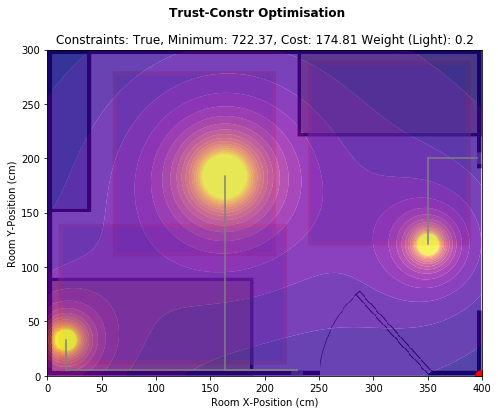

In [11]:
class PlotTestDistribution:
    """
    Two-dimensional model of light distribution in a plane with n number of light sources
    """

    def __init__(self,
                 lamp_locs = (1, 1, 1.5, 2, 3, 2.5),
                 name='',
                 refl=False,
                 save_fig=False,
                 fig_name='',
                 constrained=False,
                 cost_subsystem=False,
                 weight=-1.0):

        # These cannot be taken from the enum, as they vary upon each initialisation
        self.lamp_locs = lamp_locs
        self.name = name
        self.refl = refl
        self.save_fig = save_fig
        self.fig_name = fig_name
        self.constrained = constrained
        self.cost_subsystem = cost_subsystem
        self.weight = weight

        # Define plugs position
        self.firstplug_position = MP.F_PLUG_POSITION
        self.secondplug_position = MP.S_PLUG_POSITION

        # Plot
        if not self.cost_subsystem:
            self.plot_intensity_distr()
        else:
            self.plot_cable_distribution()

    def plot_intensity_distr(self):
        """
        Calculates the intensity distribution within a room with n number of light sources
        """

        light_intensity, minimum, minimum_coordinates = get_intensity_distr(self.lamp_locs, self.refl)

        # Fill masked areas (lamps) with maximum value
        light_intensity = ma.filled(light_intensity, np.amax(light_intensity))

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)

        # Plot background image of room
        if not self.constrained:
            img = plt.imread("../classes/room_outline.png")
        else:
            img = plt.imread("../classes/room_outline_constr.png")

        ax.imshow(img, extent=[0, MP.ROOM_LENGTH / MP.DXY, 0, MP.ROOM_WIDTH / MP.DXY])

        # Plot intensity distribution
        ax.contourf(light_intensity, MP.N_LEVELS, cmap='plasma', alpha=0.75, antialiased=True)

        # Plot global minimum
        ax.plot(minimum_coordinates[1], minimum_coordinates[0], 'ro', markersize=12)

        # Layout & Titles
        plt.suptitle(self.name + " Optimisation", fontweight='bold')

        plt.title("Reflections: " + str(self.refl) + ", Constraints: " + str(self.constrained)
                  + ", Minimum: " + str(round(minimum, 2)), fontsize='large')

        plt.xlabel('Room X-Position (cm)')
        plt.ylabel('Room Y-Position (cm)')

        # Export figure
        if self.save_fig:
            plt.savefig(self.fig_name + str(self.refl) + str(self.constrained) + '.svg', format='svg', dpi=1200)

        # Show figure

        plt.show()

    def plot_cable_distribution(self):
        """
               Calculate the position of the cables
               Also plot the the intensity distribution within a room with n number of light sources
               The later one is obtained from the light subsystem
               """

        light_intensity, minimum, minimum_coordinates = get_intensity_distr(self.lamp_locs, self.refl)

        total_cost = cost_obj_fun(self.lamp_locs)

        # Fill masked areas (lamps) with maximum value
        light_intensity = ma.filled(light_intensity, np.amax(light_intensity))

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)

        # Plot background image of room
        if not self.constrained:
            img = plt.imread("../classes/room_outline.png")
        else:
            img = plt.imread("../classes/room_outline_constr.png")

        ax.imshow(img, extent=[0, MP.ROOM_LENGTH / MP.DXY, 0, MP.ROOM_WIDTH / MP.DXY])

        # Plot intensity distribution
        ax.contourf(light_intensity, MP.N_LEVELS, cmap='plasma', alpha=0.75, antialiased=True)

        # Plot global minimum
        ax.plot(minimum_coordinates[1], minimum_coordinates[0], 'ro', markersize=12)


        #Plot cost
        for i in range(MP.N_LAMPS):

            lamp_position = [self.lamp_locs[2 * i], self.lamp_locs[2 * i + 1]]
            # Distance to first plug and second plug
            d_fp = list(map(op.sub, lamp_position, self.firstplug_position))
            d_sp = list(map(op.sub, lamp_position, self.secondplug_position))

            # Therefore cable length for L shape
            l_fp = (abs(d_fp[0]) + abs(d_fp[1]))
            l_sp = (abs(d_sp[0]) + abs(d_sp[1]))


            #Connect lamp cable to nearest plug

            if l_fp <= l_sp:
                plt.plot([100 * self.firstplug_position[0], 100 * self.lamp_locs[2 * i]],
                         [100 * self.firstplug_position[1], 100 * self.firstplug_position[1]], "grey")
                plt.plot([100 * self.lamp_locs[2 * i], 100 * self.lamp_locs[2 * i]],
                         [100 * self.firstplug_position[1], 100 * self.lamp_locs[2 * i + 1]], "grey")
            else:
                plt.plot([100 * self.secondplug_position[0], 100 * self.lamp_locs[2 * i]],
                         [100 * self.secondplug_position[1], 100 * self.secondplug_position[1]], "grey")
                plt.plot([100 * self.lamp_locs[2 * i], 100 * self.lamp_locs[2 * i]],
                         [100 * self.secondplug_position[1], 100 * self.lamp_locs[2 * i + 1]], "grey")


        # Layout & Titles
        plt.suptitle(self.name + " Optimisation", fontweight='bold')

        if self.weight <= 0.0:
            plt.title("Constraints: " + str(self.constrained) + ", Minimum: " + str(round(minimum, 2)) +
                      ", Cost: " + str(round(total_cost, 2)), fontsize='large')
        else:
            plt.title("Constraints: " + str(self.constrained) + ", Minimum: " + str(round(minimum, 2)) +
                      ", Cost: " + str(round(total_cost, 2)) + " Weight (Light): " + str(self.weight), fontsize='large')

        plt.xlabel('Room X-Position (cm)')
        plt.ylabel('Room Y-Position (cm)')
        # Export figure
        if self.save_fig:
            plt.savefig('../plots/' + self.fig_name + str(self.refl) + str(self.constrained) + str(self.cost_subsystem) + 
            	'.svg', format='svg', dpi=1200)

        # Show figure
        plt.show()

PlotTestDistribution(model.result.x, model.name, refl=model.refl, save_fig=model.save_fig, fig_name=model.name,
                         constrained=model.constrained, cost_subsystem=True, weight=0.2)


The following code plots the behaviour of both subsystems for different weigthings (Pareto set). These values are hard-coded but have been found from a set of optimisations.

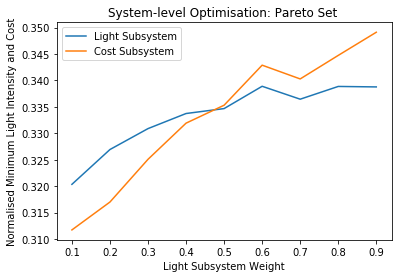

In [12]:

%matplotlib inline

weight_light_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
light_values =  np.array([717.8, 732.55, 741.41, 747.8, 749.89, 759.34, 753.87, 759.27, 759.07])
cost_values = np.array([173.73, 176.67, 181.17, 184.98, 186.87, 191.09, 189.64, 192.12, 194.56])

light_values = light_values / np.linalg.norm(light_values)
cost_values = cost_values / np.linalg.norm(cost_values)

plot = plt.figure()
plt.plot(weight_light_range, light_values)
plt.plot(weight_light_range, cost_values)
plt.legend(['Light Subsystem', 'Cost Subsystem'])
plt.title('System-level Optimisation: Pareto Set ')
plt.xlabel('Light Subsystem Weight')
plt.ylabel('Normalised Minimum Light Intensity and Cost')
plt.savefig('../plots/' + 'ParetoSet.svg', format='svg', dpi=1200)
plt.show()